In [845]:
import os
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Masking
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [846]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [847]:
tf.keras.backend.clear_session()

In [848]:
data_dir = './data/'

In [849]:
#
# Global warming: monthly temperature anomaly
# The combined land-surface air and sea-surface water temperature anomaly is given as the deviation from the 1951 - 1980 mean.
# Source: https://ourworldindata.org/explorers/climate-change?facet=none&country=~OWID_WRL&Metric=Temperature+anomaly&Long-run+series%3F=false
#

#
# Global warming: monthly sea surface temperature anomaly
# This is measured at a nominal depth of 20cm, and given relative to the average temperature from the period of 1961 - 1990.
# Source: https://ourworldindata.org/explorers/climate-change?facet=none&country=~OWID_WRL&Metric=Sea+surface+temperature+anomaly&Long-run+series%3F=false
#

df1 = pd.read_csv(data_dir + 'climate-change-air-world.csv', low_memory=False)
df1.drop(df1[df1.Entity != 'World'].index, inplace=True)
df1.drop(columns=['Code', 'Entity'], inplace=True)
df1.rename(columns={'temperature_anomaly': 'world_air_temperature_anomaly'}, inplace=True)

df2 = pd.read_csv(data_dir + 'climate-change-water-world.csv', low_memory=False)
df2.drop(df2[df2.Entity != 'World'].index, inplace=True)
df2.drop(columns=['Code', 'Entity'], inplace=True)
df2.rename(columns={'monthly_sea_surface_temperature_anomaly': 'world_sea_temperature_anomaly'}, inplace=True)

df = df1.merge(df2, on="Day", how = 'inner')
print("df.shape:")
print(df.shape)
df.head()

df.shape:
(1703, 3)


,Day,world_air_temperature_anomaly,world_sea_temperature_anomaly
0,1880-01-15,-0.17,-0.2283
1,1880-02-15,-0.22,-0.1353
2,1880-03-15,-0.08,-0.0102
3,1880-04-15,-0.15,-0.1158
4,1880-05-15,-0.08,-0.3387


In [850]:
df.tail()

,Day,world_air_temperature_anomaly,world_sea_temperature_anomaly
1698,2021-07-15,0.92,0.7308
1699,2021-08-15,0.82,0.7242
1700,2021-09-15,0.92,0.7127
1701,2021-10-15,0.98,0.6909
1702,2021-11-15,0.94,0.6813


In [851]:
orig_x_axis = df['Day'].copy(deep=True)

# The label for the predicted value - needs to be one unit bigger than what is shown in previous cell
future_x_axis = orig_x_axis.append(pd.Series(['2021-12-15']))

In [852]:
# Save main dataframe for use at the end of notebook - do a deep copy here
master_df = pd.DataFrame(df).copy(deep=True)

#
# Drop what's needed for the initial models which only uses one data column
# It is safe to drop dates (Day column) since they are all evenly spaced
#
df.drop(columns=['Day', 'world_sea_temperature_anomaly'], inplace=True)

# To keep dates must use the following (and adjust rest of code)
#df['Day'] =  pd.to_numeric(pd.to_datetime(df['Day'], format='%Y-%m-%d'))

df.head()

,world_air_temperature_anomaly
0,-0.17
1,-0.22
2,-0.08
3,-0.15
4,-0.08


In [853]:
df.tail()

,world_air_temperature_anomaly
1698,0.92
1699,0.82
1700,0.92
1701,0.98
1702,0.94


# _**Climate Change Time-Series Forecast Models**_
### Prepare the data

In [854]:
#
# Set parameter on how much to print for numpy arrays
#

#np.set_printoptions(threshold=np.inf)
np.set_printoptions(threshold=False)

In [855]:
#
# Create the dataset
#
dataset = df.values
dataset = dataset.astype('float32')


#
# Create numpy dataset
# reshape into X=t and Y=t+1
#
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
     
    for i in range(len(dataset) - look_back):  # -1
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


#
# Normalize the dataset with scikit-learn MinMaxScaler
#
np.random.seed(7)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [856]:
#
# Split into train and test sets: 70%, 30%
#
print("Dataset length:")
print(len(dataset))
print()

train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print("Training size:")
print(train_size)
print()
print("Test size:")
print(test_size)
print()

#
# Reshape into X=t and Y=t+lookback
#
look_back = 1
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

Dataset length:
1703

Training size:
1277

Test size:
426



In [857]:
# Currently the data is in the form: [samples, features] and we are framing the problem as one time step for each sample. 
# We can transform the prepared train and test input data into the expected structure using np.reshape() as follows:
#
#
#
# The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].
# ONLY THE INPUT X - NOT THE Y VALUES
#
# trainX shape: (1276, 1)
# trainY shape: (1276,)
# testX shape: (425, 1)
# testY shape: (425,)
#
#
# Reshape input to be [samples, time steps, features]
#

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print("trainX.shape:")
print(trainX.shape)
print()

print("trainY.shape:")
print(trainY.shape)
print()

print("testX.shape:")
print(testX.shape)
print()

print("testY.shape:")
print(testY.shape)
print()

trainX.shape:
(1276, 1, 1)

trainY.shape:
(1276,)

testX.shape:
(425, 1, 1)

testY.shape:
(425,)



In [858]:
#
# Get last dataset entry to make one future prediction
#

def get_last_dataset_entry():
    last_entry = df.values[len(df.values)-1]
    last_entry = last_entry.astype('float32')
    
    print("Last data point:")
    print(last_entry)
    print()
    
    last_entry = last_entry.reshape(1, -1)

    last_entry = scaler.transform(last_entry)
    last_entry = np.reshape(last_entry, (1,1,1))
    
    return last_entry

last_entry = get_last_dataset_entry()
print("Scaled last entry:")
print(last_entry)

Last data point:
[0.94]

Scaled last entry:
[[[0.8036529]]]


## **Create the Non-Stacked LSTM Model**

In [859]:
#
# Create LSTM model #1 (unstacked)
#


# TODO: Fix this so there is not a gap between train and test - let train data look in one element into test
def create_nonstacked_lstm_model(trainX, trainY, testX, testY, lrate, loss_type, epochs, look_back, batch_size):

    model_unstacked = Sequential([
        LSTM(20, stateful=False, input_shape=(trainX.shape[1],1), name='layer1'),         # , batch_input_shape(64,10,1)  batch_input_shape=(1, look_back)
        Dense(1, name='Output')
    ])
    
    opt = Adam(learning_rate=lrate)
    
    model_unstacked.compile(loss=loss_type, optimizer=opt, metrics=['accuracy', 'mae', 'mse'])
    
    model_unstacked.summary()
    
    earlystopping = EarlyStopping(
        monitor='val_loss', 
        mode ='min',
        patience=15,
        verbose=1,
        restore_best_weights=True
    )
    
    tensorboard = TensorBoard(
        log_dir='./tensorboard/nonstacked_model/',
        histogram_freq=1,
        write_images=True,
        write_graph=True,
        embeddings_freq=1
    )

    history_unstacked = model_unstacked.fit(
        trainX,
        trainY,
        shuffle=False,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        validation_data=(testX, testY),
        callbacks = [earlystopping, tensorboard]
    )
    
    return history_unstacked, model_unstacked

## **Create the Stacked LSTM Model**

In [871]:
#
# Create LSTM model #2 - stacked
#


def create_stacked_lstm_model(trainX, trainY, testX, testY, lrate, loss_type, epochs, look_back, batch_size):
    
    model_stacked = Sequential([
        LSTM(20, return_sequences=True, input_shape=(trainX.shape[1],1), name='layer1'),
        #Dropout(0.1),
        LSTM(20, return_sequences=False, name='layer2'),
        #Dropout(0.1),
        Dense(1, name='Output')
    ])

    opt = Adam(learning_rate=lrate)
    
    model_stacked.compile(loss=loss_type, optimizer=opt, metrics=['accuracy', 'mae', 'mse'])
    
    model_stacked.summary()
    
    earlystopping = EarlyStopping(
        monitor='val_loss', 
        mode ='min',
        patience=15,
        verbose=1,
        restore_best_weights=True
    )
    
    tensorboard = TensorBoard(
        log_dir='./tensorboard/stacked_model/',
        histogram_freq=1,
        write_images=True,
        write_graph=True,
        embeddings_freq=1
    )
    
    history_stacked = model_stacked.fit(
        trainX,
        trainY,
        shuffle=False,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        validation_data=(testX, testY),
        callbacks = [earlystopping, tensorboard]
    )

    return history_stacked, model_stacked

## **Create the Bidirectional LSTM Model**

In [872]:
#
# Create LSTM model #3 - Bidirectional
#


def create_bidirectional_lstm_model(trainX, trainY, testX, testY, lrate, loss_type, epochs, look_back, batch_size):
    
    bidirectional_model = Sequential([
        Bidirectional(LSTM(20, activation='relu'), input_shape=(trainX.shape[1],1), name='layer1'),
        Dense(1, name='Output')
    ])

    opt = Adam(learning_rate=lrate)
    
    bidirectional_model.compile(loss=loss_type, optimizer=opt, metrics=['accuracy', 'mae', 'mse'])
    
    bidirectional_model.summary()
    
    earlystopping = EarlyStopping(
        monitor='val_loss', 
        mode ='min',
        patience=15,
        verbose=1,
        restore_best_weights=True
    )
    
    tensorboard = TensorBoard(
        log_dir='./tensorboard/bidirectional_model/',
        histogram_freq=1,
        write_images=True,
        write_graph=True,
        embeddings_freq=1
    )
    
    bidirectional_history = bidirectional_model.fit(
        trainX,
        trainY,
        shuffle=False,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        validation_data=(testX, testY),
        callbacks = [earlystopping, tensorboard]
    )

    return bidirectional_history, bidirectional_model

## **Create the Stacked Bidirectional LSTM Model**

In [862]:
#
# Create LSTM model #4 - Stacked, Bidirectional
#


def create_stacked_bidirectional_lstm_model(trainX, trainY, testX, testY, lrate, loss_type, epochs, look_back, batch_size):
    
    stacked_bidirectional_model = Sequential([
        Bidirectional(LSTM(20, return_sequences=True), input_shape=(trainX.shape[1],1), name='layer1'),
        Bidirectional(LSTM(20, return_sequences=False), name='layer2'),
        Dense(1, name='Output')
    ])

    opt = Adam(learning_rate=lrate)
    
    stacked_bidirectional_model.compile(loss=loss_type, optimizer=opt, metrics=['accuracy', 'mae', 'mse'])
    
    stacked_bidirectional_model.summary()
    
    earlystopping = EarlyStopping(
        monitor='val_loss', 
        mode ='min',
        patience=15,
        verbose=1,
        restore_best_weights=True
    )
    
    tensorboard = TensorBoard(
        log_dir='./tensorboard/stacked_bidirectional_model/',
        histogram_freq=1,
        write_images=True,
        write_graph=True,
        embeddings_freq=1
    )
    
    stacked_bidirectional_history = stacked_bidirectional_model.fit(
        trainX,
        trainY,
        shuffle=False,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        validation_data=(testX, testY),
        callbacks = [earlystopping, tensorboard]
    )

    return stacked_bidirectional_history, stacked_bidirectional_model

## **Run the Non-stacked Model**

In [863]:
#
# Run non-stacked model version
#

tf.keras.backend.clear_session()

lrate = 0.00003
look_back = 1
batch_size = 1
loss_type = 'mean_squared_error'
num_epochs = 1000   # 400

history_nonstacked_lstm, lstm_nonstacked_model = create_nonstacked_lstm_model(trainX, trainY, testX, testY, lrate, loss_type, num_epochs, look_back, batch_size)

lstm_nonstacked_model.save('./models/lstm_nonstacked_model_1')
    
#
# Predictions
#
trainPredict = lstm_nonstacked_model.predict(trainX)
testPredict = lstm_nonstacked_model.predict(testX)
    
#
# Make next time period prediction
#
future_prediction = lstm_nonstacked_model.predict(last_entry)
print("Future Prediction scaled: " + str(future_prediction))
future_prediction = scaler.inverse_transform(future_prediction)
print("Future Prediction unscaled: " + str(future_prediction))

#
# Invert predictions back using the scalar
#
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform([testY])


#
# Calculate root mean squared error
#
#print()
trainScore = math.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

score_lstm = lstm_nonstacked_model.evaluate(testX, testY, verbose=1)
print("Model's Evaluation Score:")
print(score_lstm)

print('mean-squared-error:')
print(mean_squared_error(testY_orig[0], testPredict))

print('mean-absolute-error:')
print(mean_absolute_error(testY_orig[0], testPredict))


print('r2-score:')
print(r2_score(testY_orig[0], testPredict))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (LSTM)               (None, 16)                1152      
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1276/1276 - 3s - loss: 0.1053 - accuracy: 7.8370e-04 - mae: 0.3122 - mse: 0.1053 - val_loss: 0.3768 - val_accuracy: 0.0000e+00 - val_mae: 0.6023 - val_mse: 0.3768 - 3s/epoch - 2ms/step
Epoch 2/1000
1276/1276 - 1s - loss: 0.0648 - accuracy: 7.8370e-04 - mae: 0.2398 - mse: 0.0648 - val_loss: 0.2821 - val_accuracy: 0.0000e+00 - val_mae: 0.5188 - val_mse: 0.2821 - 1s/epoch - 1ms/step
Epoch 3/1000
1276/1276 - 1s - loss: 0.0368 - accuracy:

INFO:tensorflow:Assets written to: ./models/lstm_nonstacked_model_1/assets


INFO:tensorflow:Assets written to: ./models/lstm_nonstacked_model_1/assets


Future Prediction scaled: [[0.7665137]]
Future Prediction unscaled: [[0.8586651]]
Train Score: 0.12 RMSE
Test Score: 0.14 RMSE
14/14 [==============================] - 0s 1ms/step - loss: 0.0039 - accuracy: 0.0024 - mae: 0.0505 - mse: 0.0039
Model's Evaluation Score:
[0.003865616163238883, 0.002352941082790494, 0.0505472868680954, 0.003865616163238883]
mean-squared-error:
0.01853988640607436
mean-absolute-error:
0.11069857897900835
r2-score:
0.7094557255404979


In [874]:
print(lstm_nonstacked_model.metrics_names)

['loss', 'accuracy', 'mae', 'mse']


## **Plot the Non-stacked Model**

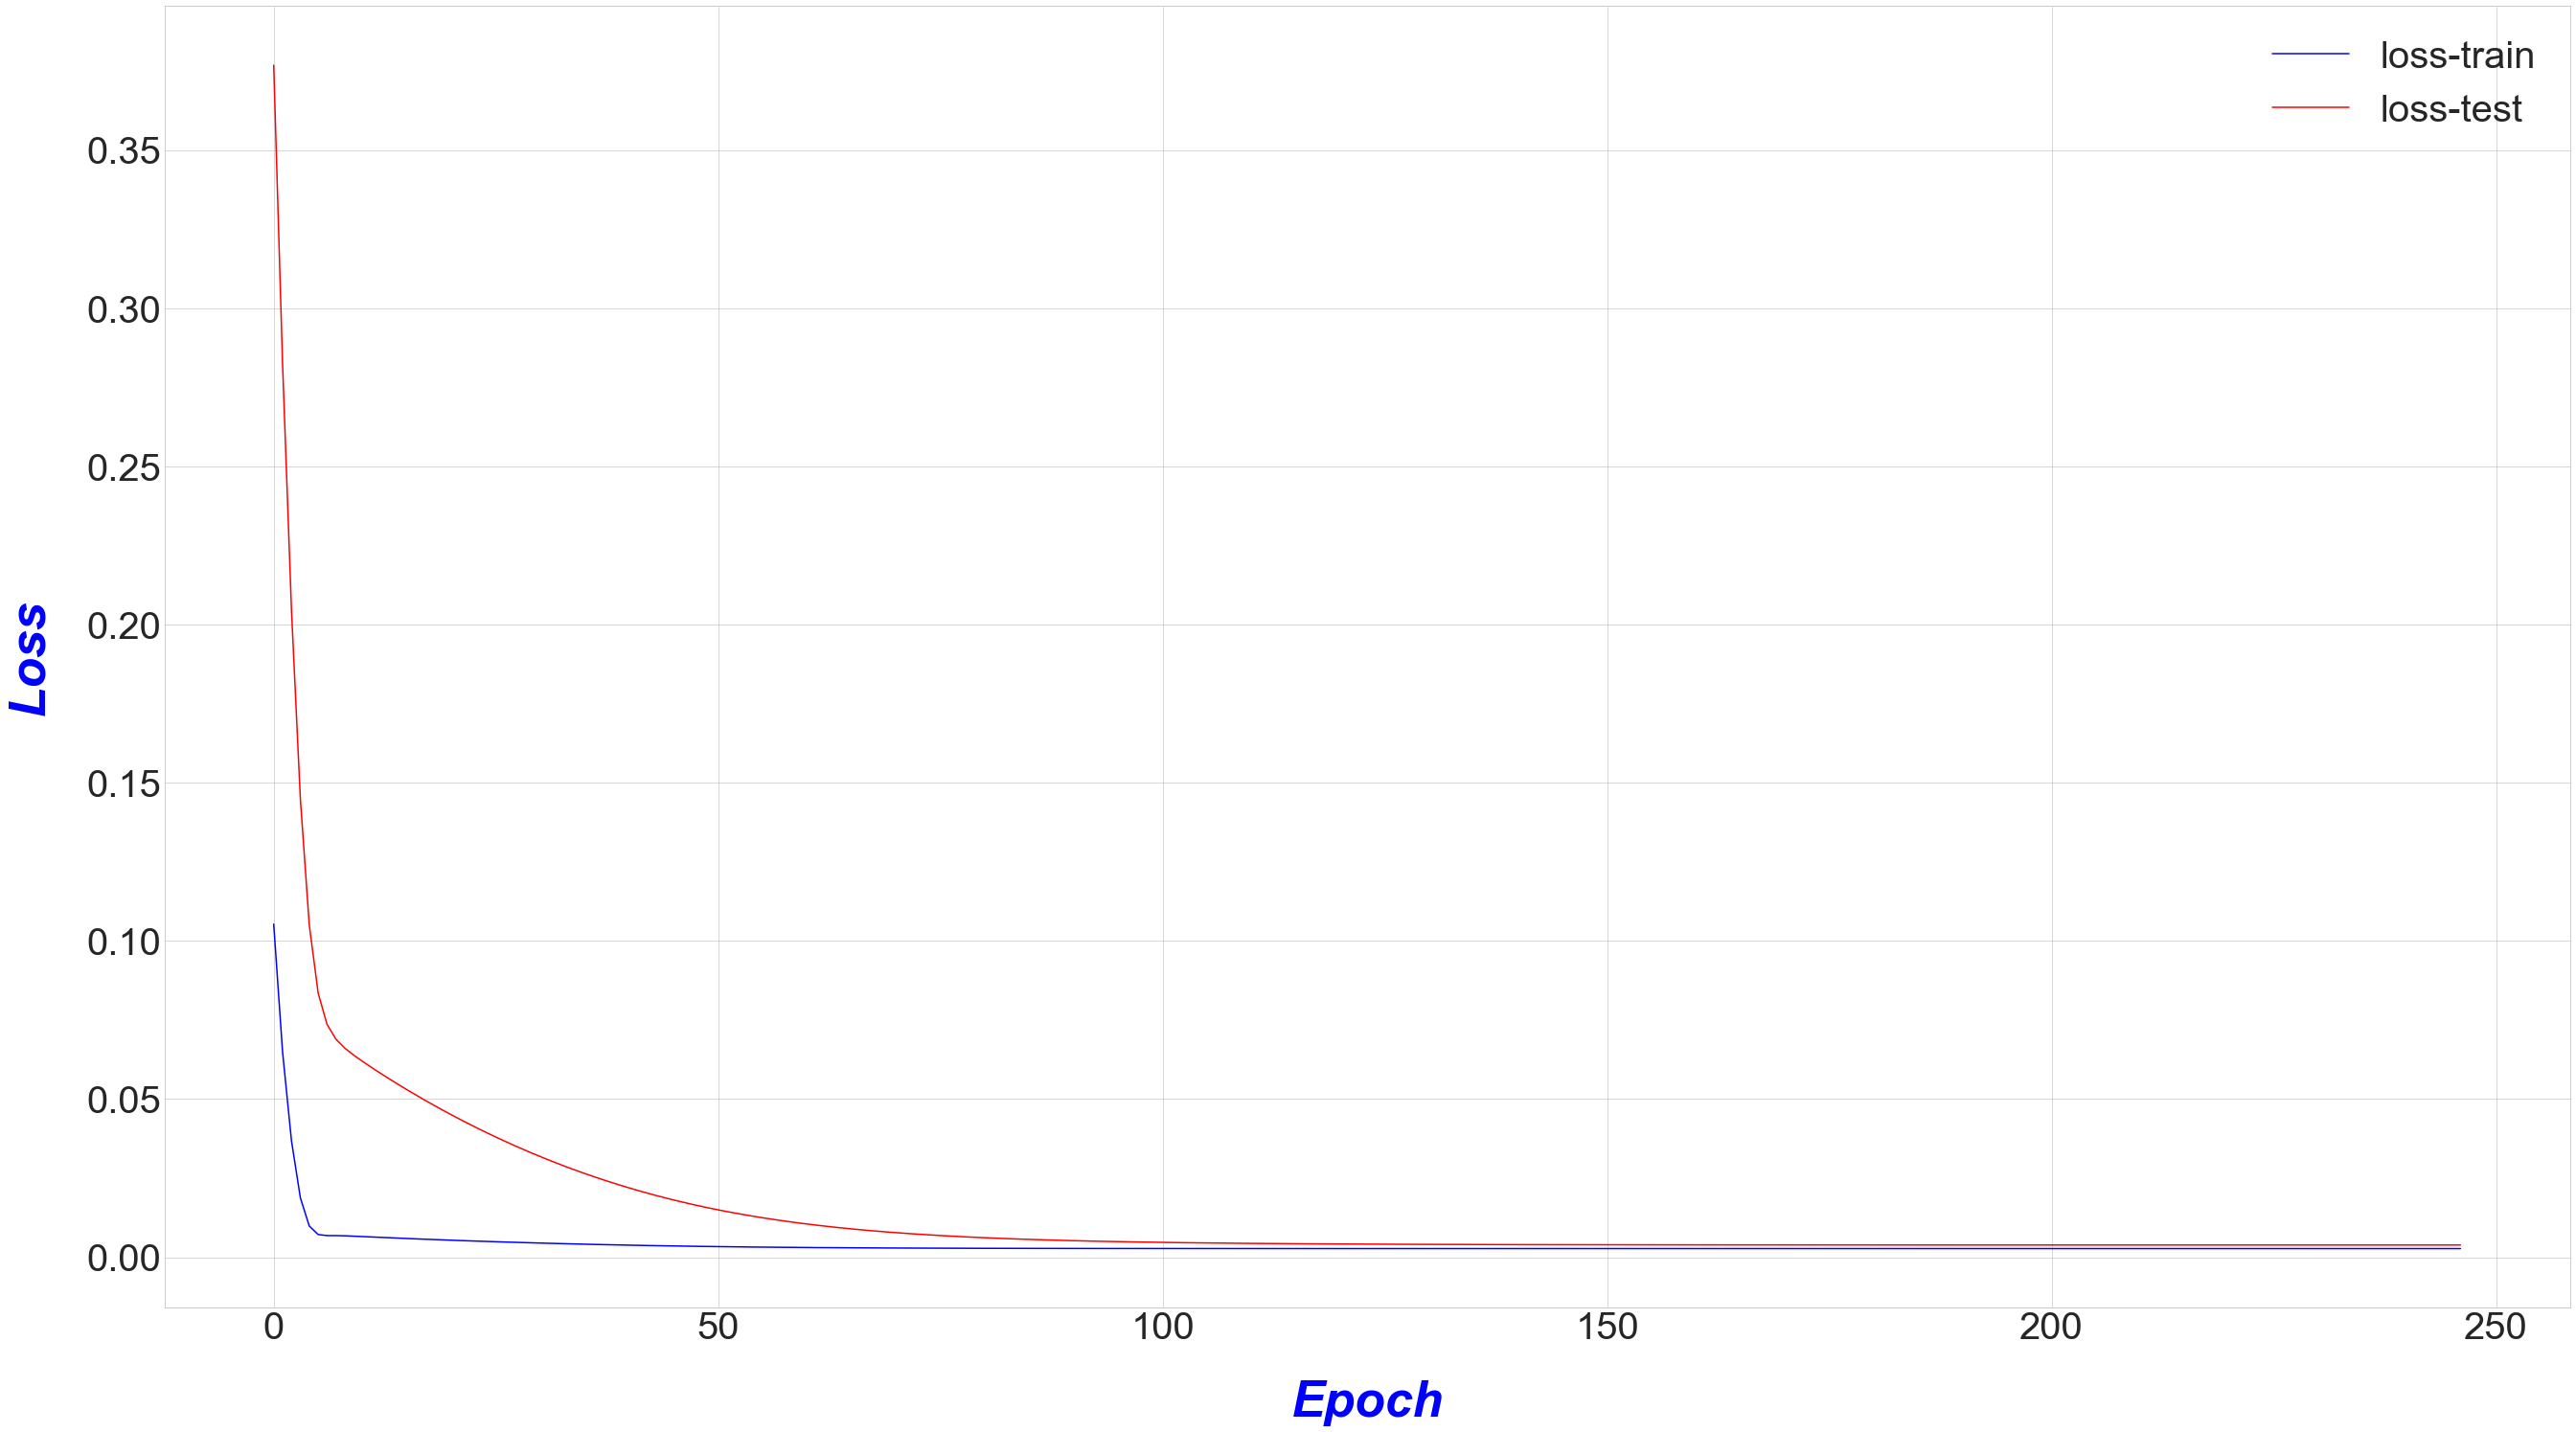

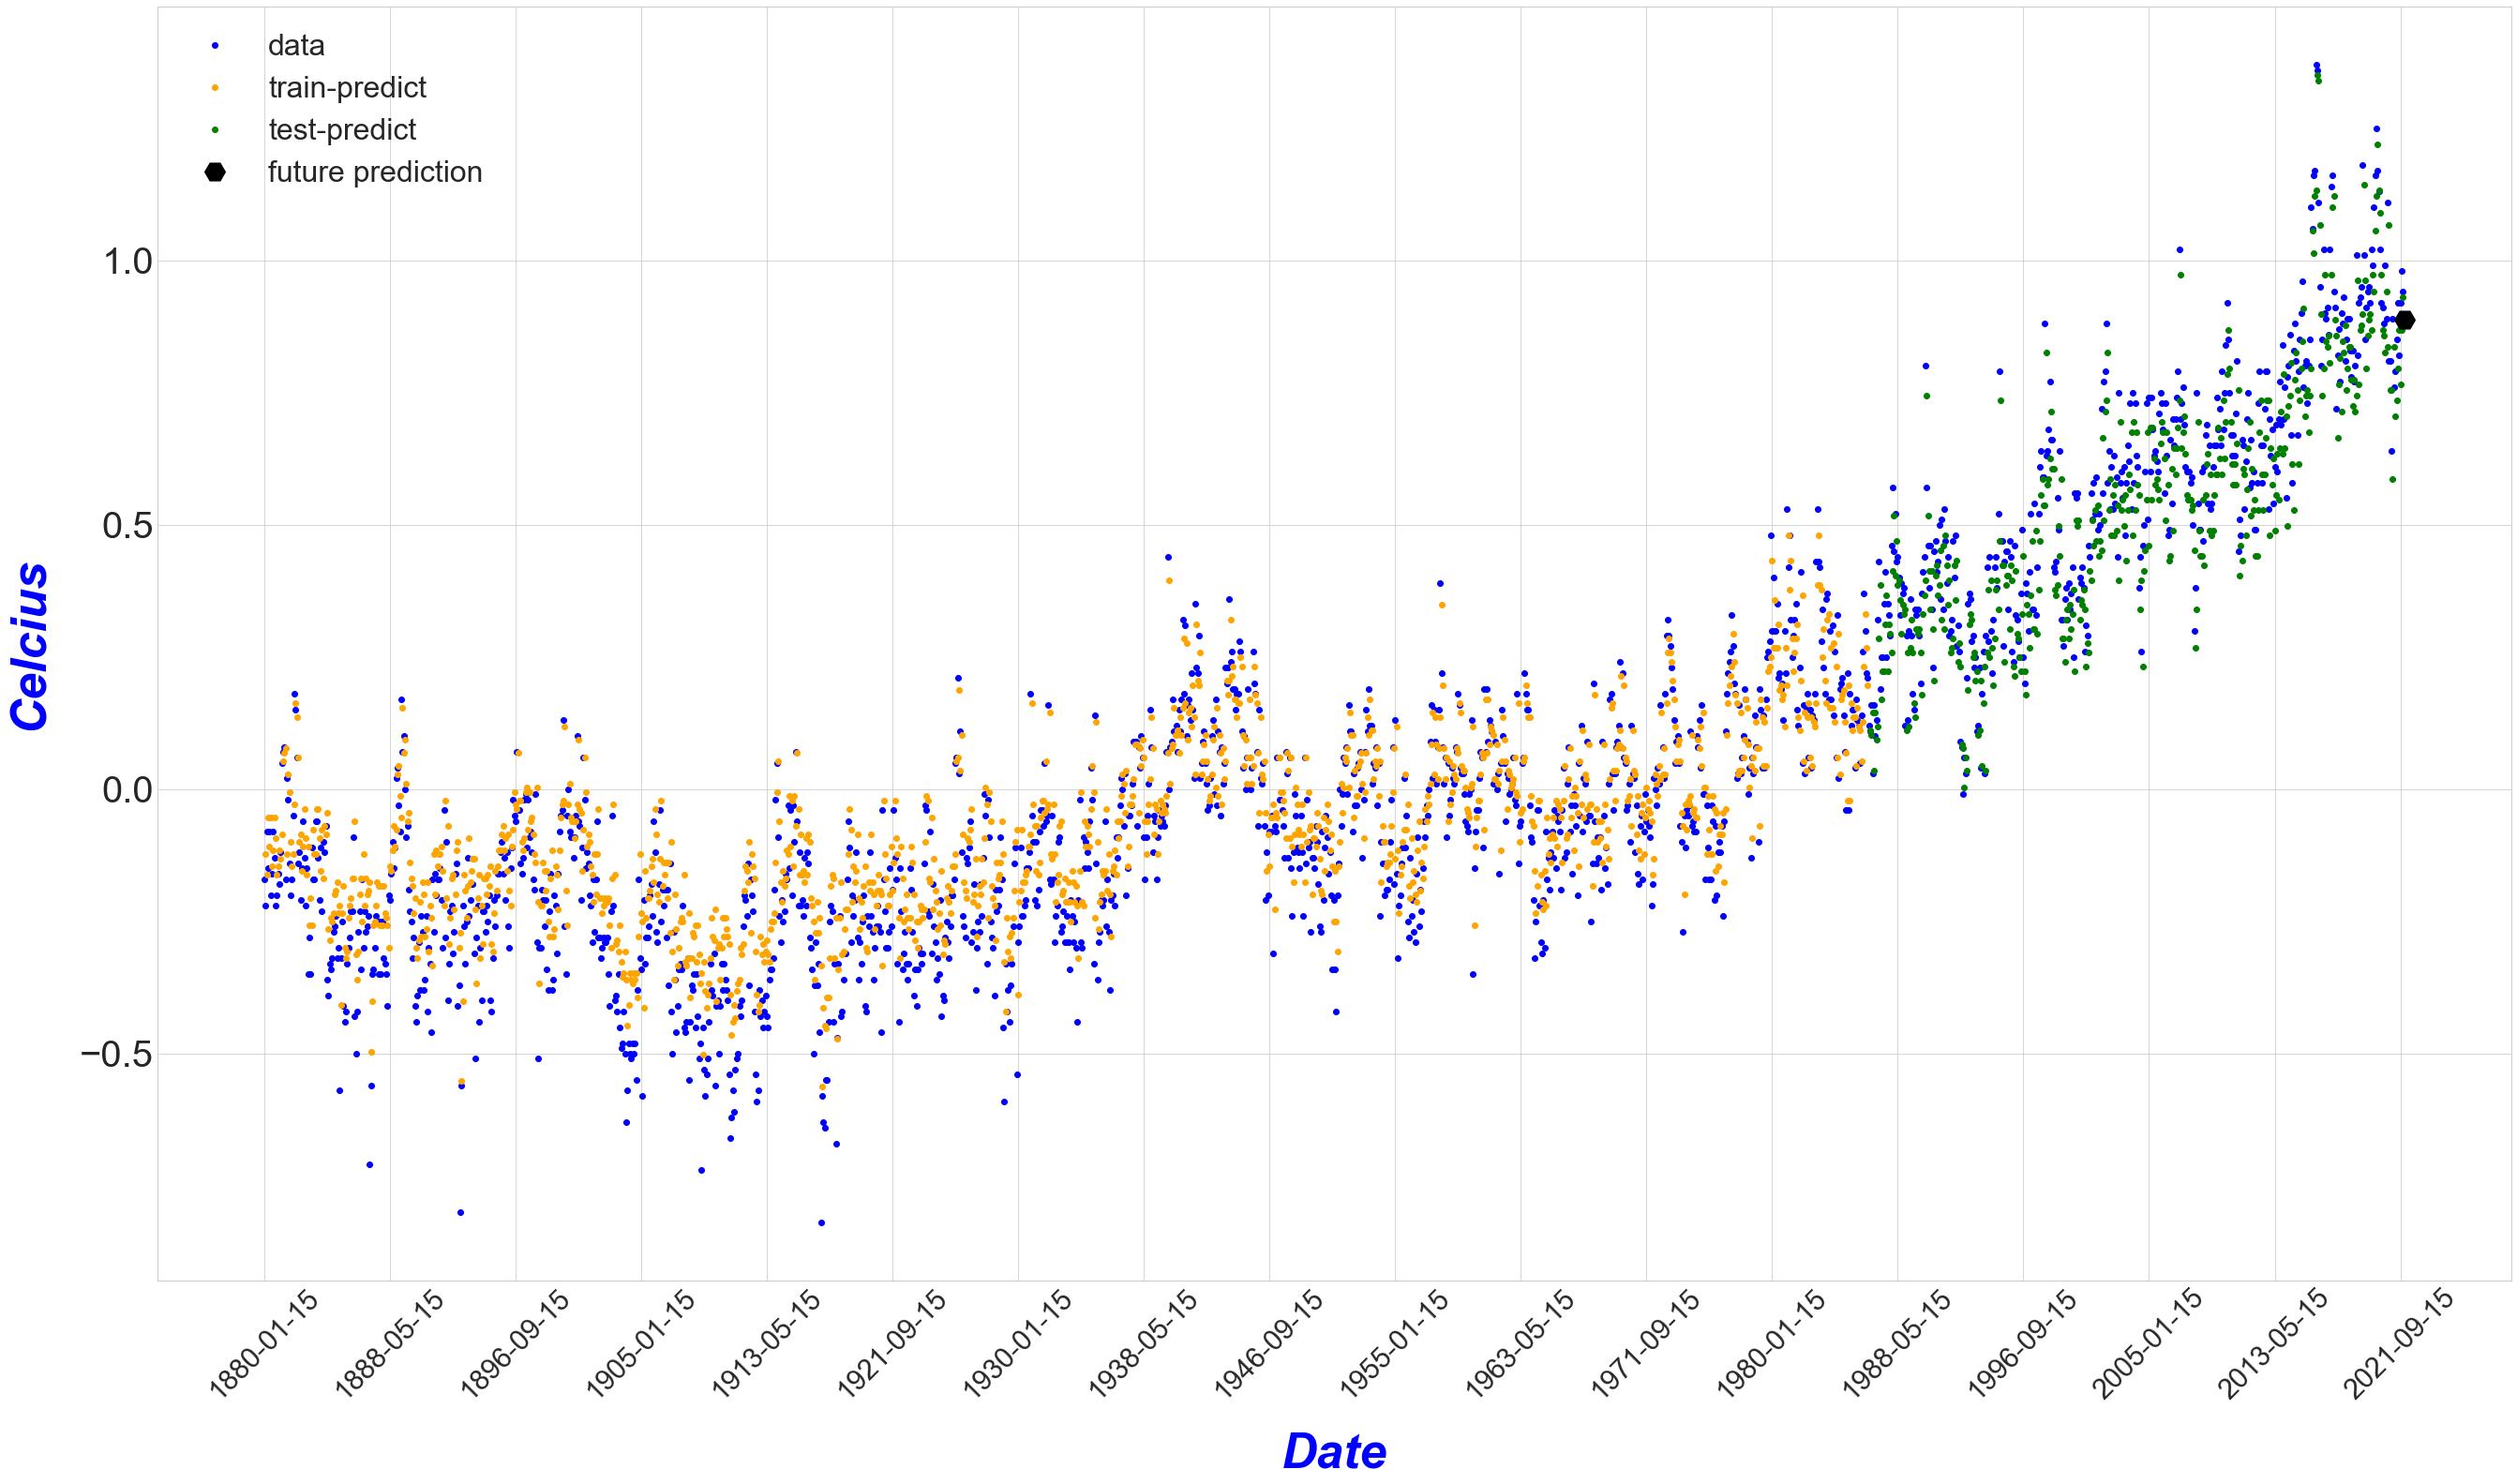

In [880]:
#
# Plot for non-stacked model
#

plt.style.use('seaborn-whitegrid')

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
testPredictPlot[len(trainPredict)+(look_back)+1:len(dataset), :] = testPredict
    
futurePredictPlot = np.empty_like(dataset)
futurePredictPlot[:, :] = np.nan
futurePredictPlot = np.append(futurePredictPlot, future_prediction)

epochs = range(len(history_nonstacked_lstm.history['loss']))

#
# Plot Loss graph
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")

#pyplot.plot(history.history['accuracy'], label='train')
#pyplot.plot(history.history['val_accuracy'], label='test')
#plt.plot(epochs, history_nonstacked_lstm.history['mse'], "b", label='loss-train')
#plt.plot(epochs, history_nonstacked_lstm.history['val_mse'], "r", label='loss-test')

plt.plot(epochs, history_nonstacked_lstm.history['loss'], "b", label='loss-train')
plt.plot(epochs, history_nonstacked_lstm.history['val_loss'], "r", label='loss-test')

#plt.suptitle('LSTM Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam)', fontsize=60, weight='bold', style='italic', color='black')
#plt.title('LSTM Loss (learning-rate=' + str(lrate) + ')' + ', Train Score: %.3f RMSE' % (trainScore) + ', Test Score: %.2f RMSE' % (testScore), fontsize=50, weight='normal', style='italic', color='black', pad=30)
ax.legend(fontsize=40)
ax.tick_params(axis='both', labelsize=32)
ax.set_xlabel('Epoch', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.set_ylabel('Loss', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

plt.grid(True)

plt.savefig("./images/lstm-nonstacked-loss.png")
plt.show();

    
#
# Time prediction plot
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")

plt.plot(orig_x_axis, scaler.inverse_transform(dataset), 'bo', markersize=6, label="data")  # Blue
plt.plot(orig_x_axis, trainPredictPlot, 'o', color='orange', markersize=6, label='train-predict')  # Orange
plt.plot(orig_x_axis, testPredictPlot, 'go', markersize=6, label='test-predict')   # Green
plt.plot(future_x_axis, futurePredictPlot, 'kH', markersize=22, label='future prediction')

#plt.suptitle('LSTM Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam)', fontsize=60, weight='bold', style='italic', color='black')
#plt.title('LSTM Train, Test, Future Predictions - Future Prediction = %.4f C' % future_prediction[0][0], fontsize=50, weight='normal', style='italic', color='black', pad=38)

ax.legend(fontsize=32)
ax.tick_params(labelsize=20, width=20)
ax.set_xlabel('Date', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.set_ylabel('Celcius', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.xaxis.set_major_locator(ticker.MaxNLocator(20))
ax.xaxis.set_minor_locator(ticker.MaxNLocator(40))
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=30)
plt.yticks(fontsize=40)

plt.grid(True)

plt.savefig("./images/lstm-nonstacked-plot.png")
plt.show();

## **Run the Stacked Model**

In [873]:
#
# Stacked layer LSTM
#

tf.keras.backend.clear_session()

lrate = 0.00003
look_back = 1
batch_size = 1
loss_type = 'mean_squared_error'
num_epochs = 1000   # 400

history_stacked_lstm, lstm_stacked_model = create_stacked_lstm_model(trainX, trainY, testX, testY, lrate, loss_type, num_epochs, look_back, 1)
lstm_stacked_model.save('./models/lstm_stacked_model_1')
    
#
# Predictions
#
trainPredict = lstm_stacked_model.predict(trainX)
testPredict = lstm_stacked_model.predict(testX)
    
#
# Make next time period prediction
#
print("Last Entry:")
print(last_entry)
future_prediction = lstm_stacked_model.predict(last_entry)
print("Future Prediction scaled: " + str(future_prediction))
future_prediction = scaler.inverse_transform(future_prediction)
print("Future Prediction unscaled: " + str(future_prediction))

#
# Invert predictions back using the scalar
#
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform([testY])

#
# Calculate root mean squared error
#
#print()
trainScore = math.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

score_lstm = lstm_stacked_model.evaluate(testX, testY, verbose=1)
print("Model's Evaluation Score:")
print(score_lstm)

print('mean-squared-error:')
print(mean_squared_error(testY_orig[0], testPredict))

print('mean-absolute-error:')
print(mean_absolute_error(testY_orig[0], testPredict))

print('r2-score:')
print(r2_score(testY_orig[0], testPredict))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (LSTM)               (None, 1, 20)             1760      
                                                                 
 dropout (Dropout)           (None, 1, 20)             0         
                                                                 
 layer2 (LSTM)               (None, 20)                3280      
                                                                 
 Output (Dense)              (None, 1)                 21        
                                                                 
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1276/1276 - 4s - loss: 0.0707 - accuracy: 7.8370e-04 - mae: 0.2555 - mse: 0.0707 - val_loss: 0.2252 - val_accuracy: 0.0000e+00 - val_mae: 0.4625 - val_mse: 0.2252 - 4s/epoch

INFO:tensorflow:Assets written to: ./models/lstm_stacked_model_1/assets


INFO:tensorflow:Assets written to: ./models/lstm_stacked_model_1/assets


Last Entry:
[[[0.8036529]]]
Future Prediction scaled: [[0.77998567]]
Future Prediction unscaled: [[0.8881687]]
Train Score: 0.12 RMSE
Test Score: 0.13 RMSE
14/14 [==============================] - 1s 1ms/step - loss: 0.0035 - accuracy: 0.0024 - mae: 0.0481 - mse: 0.0035
Model's Evaluation Score:
[0.0035413485020399094, 0.002352941082790494, 0.048124272376298904, 0.0035413485020399094]
mean-squared-error:
0.016984661893192265
mean-absolute-error:
0.1053921637312524
r2-score:
0.733828128252141


In [875]:
print(lstm_stacked_model.metrics_names)

['loss', 'accuracy', 'mae', 'mse']


## **Plot the Stacked Model**

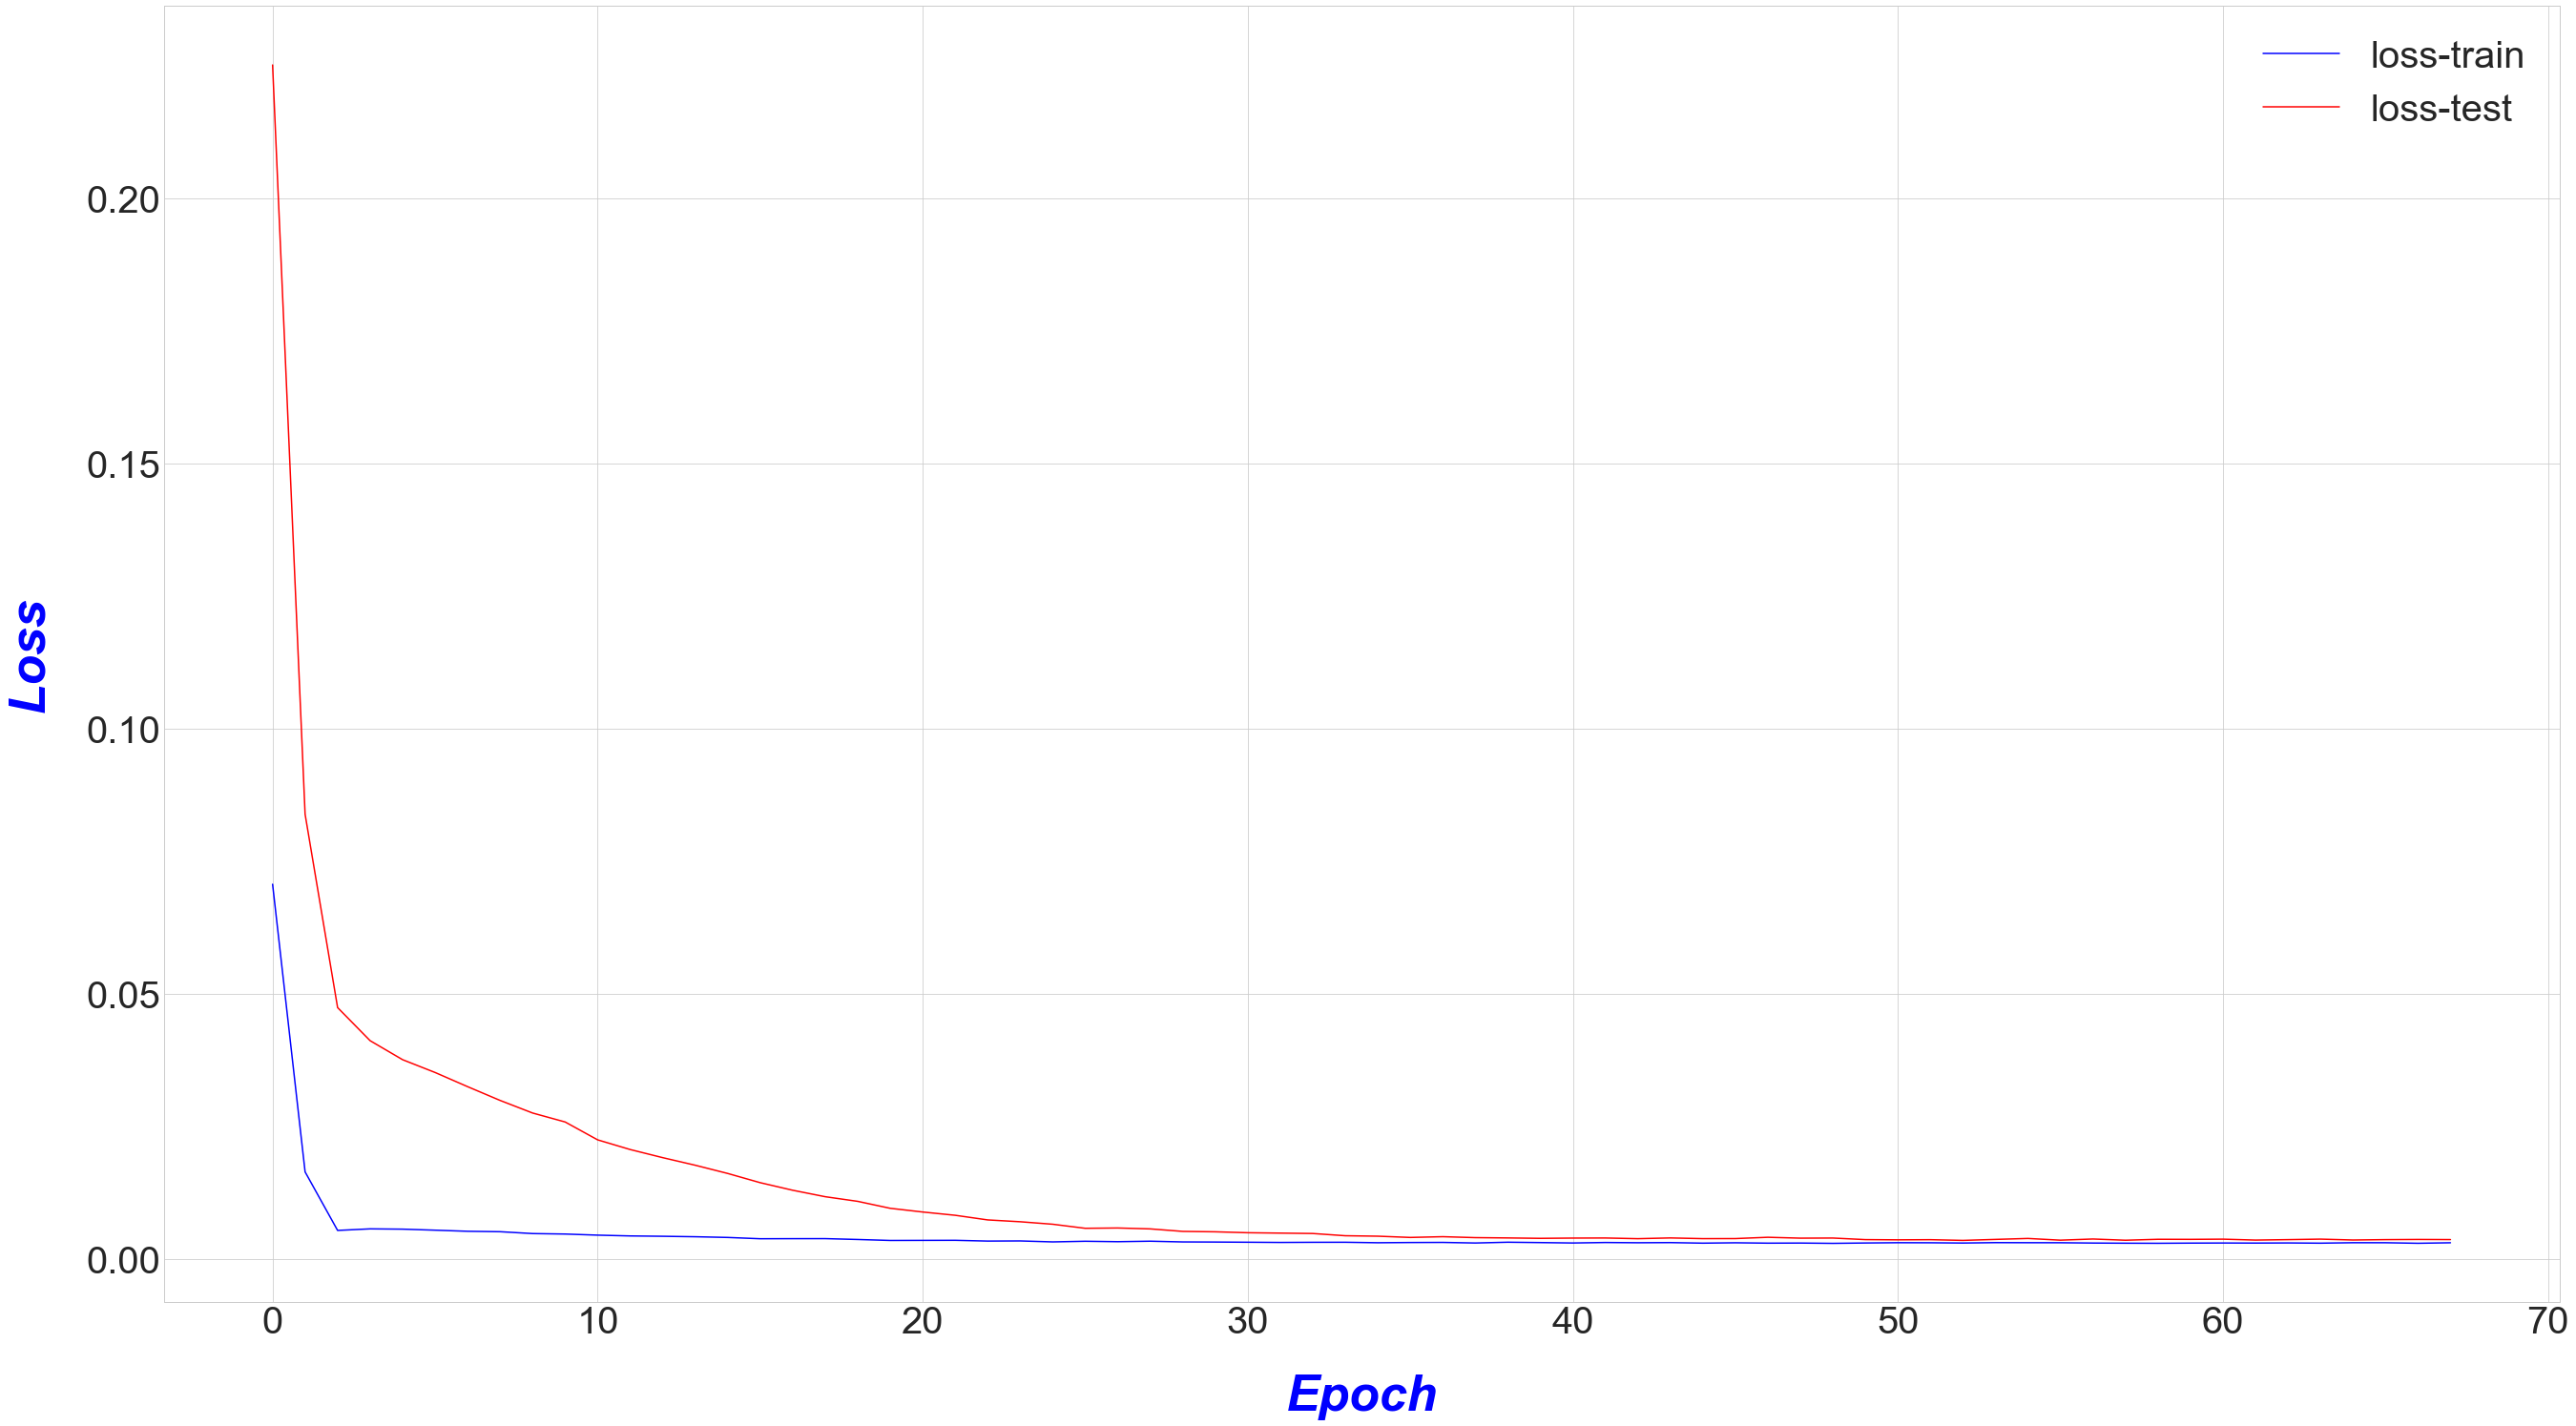

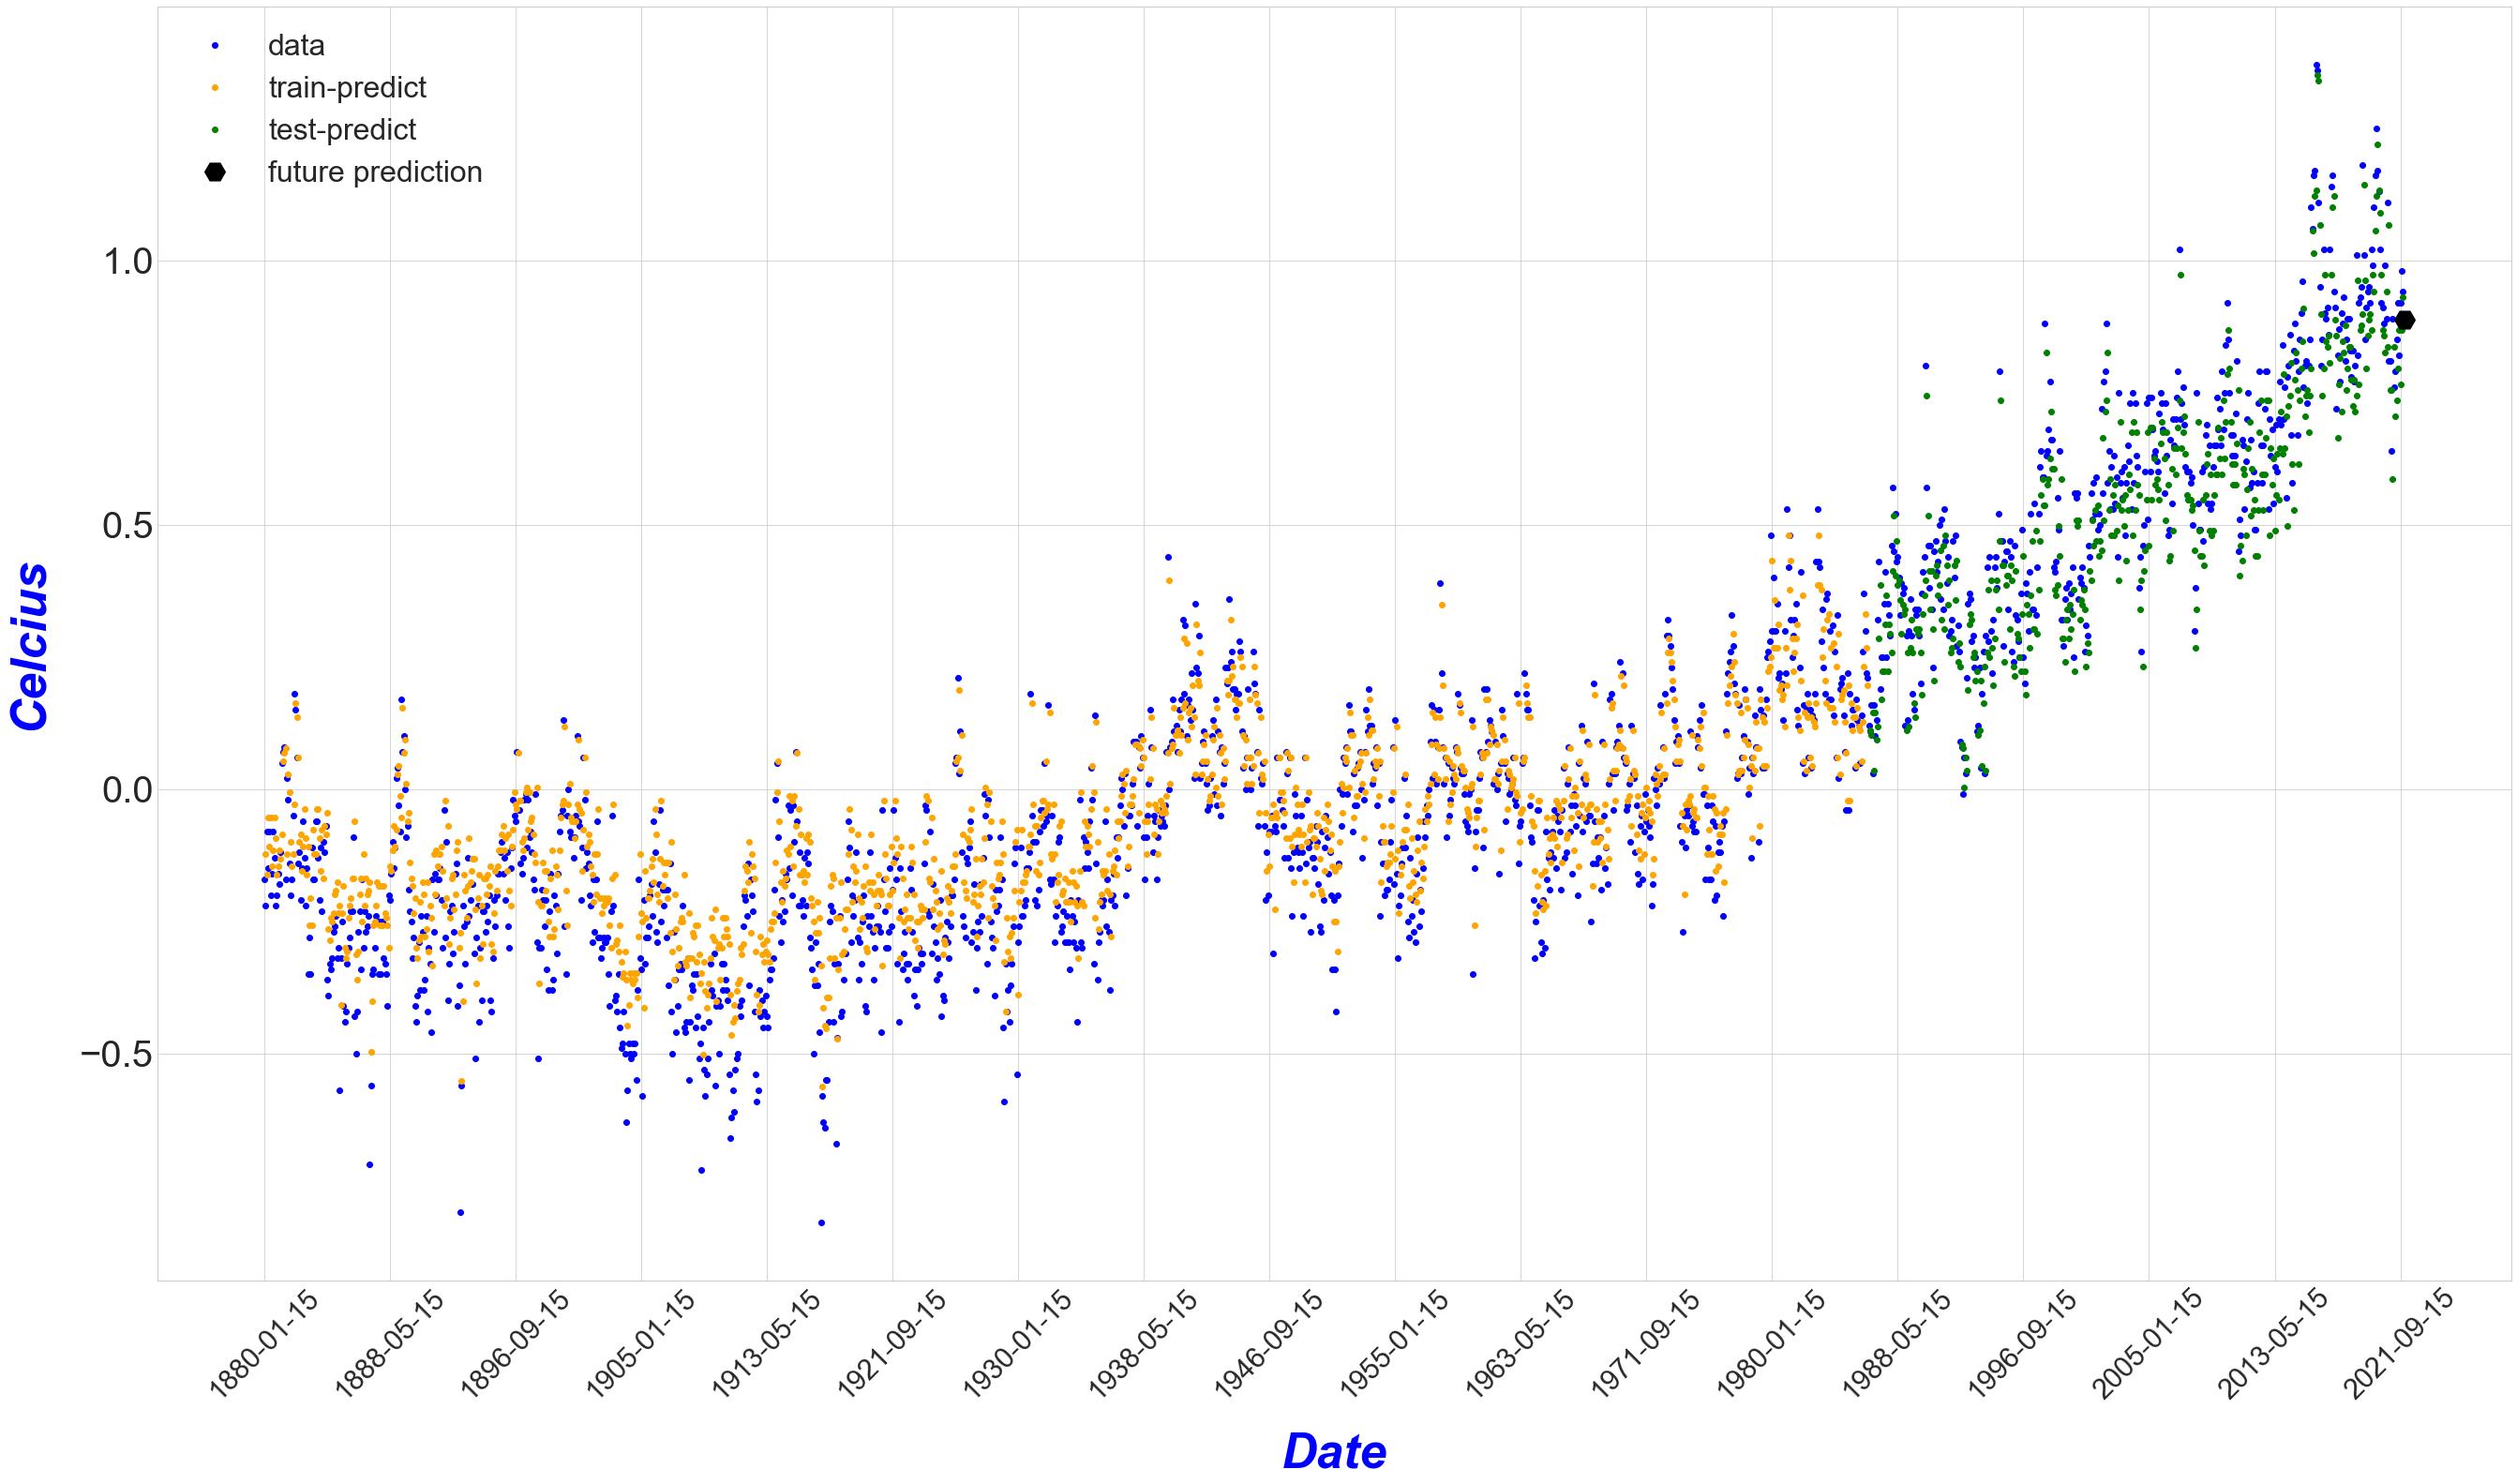

In [877]:
#
# Plot for stacked LSTM model
#

plt.style.use('seaborn-whitegrid')

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
testPredictPlot[len(trainPredict)+(look_back)+1:len(dataset), :] = testPredict

futurePredictPlot = np.empty_like(dataset)
futurePredictPlot[:, :] = np.nan
futurePredictPlot = np.append(futurePredictPlot, future_prediction)

epochs = range(len(history_stacked_lstm.history['loss']))

#
# Plot Loss graph
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")

plt.plot(epochs, history_stacked_lstm.history['loss'], "b", label='loss-train')
plt.plot(epochs, history_stacked_lstm.history['val_loss'], "r", label='loss-test')

#plt.suptitle('LSTM Stacked Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam)', fontsize=60, weight='bold', style='italic', color='black')
#plt.title('LSTM Loss (learning-rate=' + str(lrate) + ')' + ', Train Score: %.3f RMSE' % (trainScore) + ', Test Score: %.2f RMSE' % (testScore), fontsize=50, weight='normal', style='italic', color='black', pad=30)
ax.legend(fontsize=40)
ax.tick_params(axis='both', labelsize=32)
ax.set_xlabel('Epoch', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.set_ylabel('Loss', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(True)
plt.savefig("./images/lstm-stacked-loss.png")
plt.show();

    
#
# Time prediction plot
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")
plt.plot(orig_x_axis, scaler.inverse_transform(dataset), 'bo', markersize=6, label="data")  # Blue
plt.plot(orig_x_axis, trainPredictPlot, 'o', color='orange', markersize=6, label='train-predict')  # Orange
plt.plot(orig_x_axis, testPredictPlot, 'go', markersize=6, label='test-predict')   # Green
plt.plot(future_x_axis, futurePredictPlot, 'kH', markersize=22, label='future prediction')

#plt.suptitle('LSTM Stacked Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam)', fontsize=60, weight='bold', style='italic', color='black')
#plt.title('LSTM Train, Test, Future Predictions - Future Prediction = %.4f C' % future_prediction[0][0], fontsize=50, weight='normal', style='italic', color='black', pad=38)

ax.legend(fontsize=32)
ax.tick_params(labelsize=20, width=20) #ax.tick_params(labelcolor='r', labelsize='medium', width=3)
ax.set_xlabel('Date', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.set_ylabel('Celcius', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.xaxis.set_major_locator(ticker.MaxNLocator(20))
ax.xaxis.set_minor_locator(ticker.MaxNLocator(40))
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=30)
plt.yticks(fontsize=40)
plt.grid(True)
plt.savefig("./images/lstm-stacked-plot.png")
plt.show();

## **Run the Bidirectional Model**

In [867]:
#
# Bidirectional layer LSTM
#

tf.keras.backend.clear_session()

lrate = 0.00003
look_back = 1
batch_size = 1
loss_type = 'mean_squared_error'
num_epochs = 1000   # 300

history_bidirectional_lstm, lstm_bidirectional_model = create_bidirectional_lstm_model(trainX, trainY, testX, testY, lrate, loss_type, num_epochs, look_back, 1)
lstm_bidirectional_model.save('./models/lstm_bidirectional_model_1')
    
#
# Predictions
#
trainPredict = lstm_bidirectional_model.predict(trainX)
testPredict = lstm_bidirectional_model.predict(testX)
    
#
# Make next time period prediction
#
print("Last Entry:")
print(last_entry)
future_prediction = lstm_bidirectional_model.predict(last_entry)
print("Future Prediction scaled: " + str(future_prediction))
future_prediction = scaler.inverse_transform(future_prediction)
print("Future Prediction unscaled: " + str(future_prediction))

#
# Invert predictions back using the scalar
#
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform([testY])

#
# Calculate root mean squared error
#
#print()
trainScore = math.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

score_lstm = lstm_bidirectional_model.evaluate(testX, testY, verbose=1)
print("Model's Evaluation Score:")
print(score_lstm)

print('mean-squared-error:')
print(mean_squared_error(testY_orig[0], testPredict))

print('mean-absolute-error:')
print(mean_absolute_error(testY_orig[0], testPredict))

print('r2-score:')
print(r2_score(testY_orig[0], testPredict))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Bidirectional)      (None, 32)                2304      
                                                                 
 Output (Dense)              (None, 1)                 33        
                                                                 
Total params: 2,337
Trainable params: 2,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1276/1276 - 3s - loss: 0.0964 - accuracy: 7.8370e-04 - mae: 0.2981 - mse: 0.0964 - val_loss: 0.3541 - val_accuracy: 0.0000e+00 - val_mae: 0.5843 - val_mse: 0.3541 - 3s/epoch - 2ms/step
Epoch 2/1000
1276/1276 - 2s - loss: 0.0702 - accuracy: 7.8370e-04 - mae: 0.2512 - mse: 0.0702 - val_loss: 0.2933 - val_accuracy: 0.0000e+00 - val_mae: 0.5302 - val_mse: 0.2933 - 2s/epoch - 1ms/step
Epoch 3/1000
1276/1276 - 2s - loss: 0.0500 - accuracy:

INFO:tensorflow:Assets written to: ./models/lstm_bidirectional_model_1/assets


Last Entry:
[[[0.8036529]]]
Future Prediction scaled: [[0.797224]]
Future Prediction unscaled: [[0.9259206]]
Train Score: 0.12 RMSE
Test Score: 0.13 RMSE
14/14 [==============================] - 0s 1ms/step - loss: 0.0036 - accuracy: 0.0024 - mae: 0.0481 - mse: 0.0036
Model's Evaluation Score:
[0.0035595607478171587, 0.002352941082790494, 0.04811831936240196, 0.0035595607478171587]
mean-squared-error:
0.017072009667192745
mean-absolute-error:
0.10537912088145925
r2-score:
0.7324592743623832


## **Plot the Bidirectional Model**

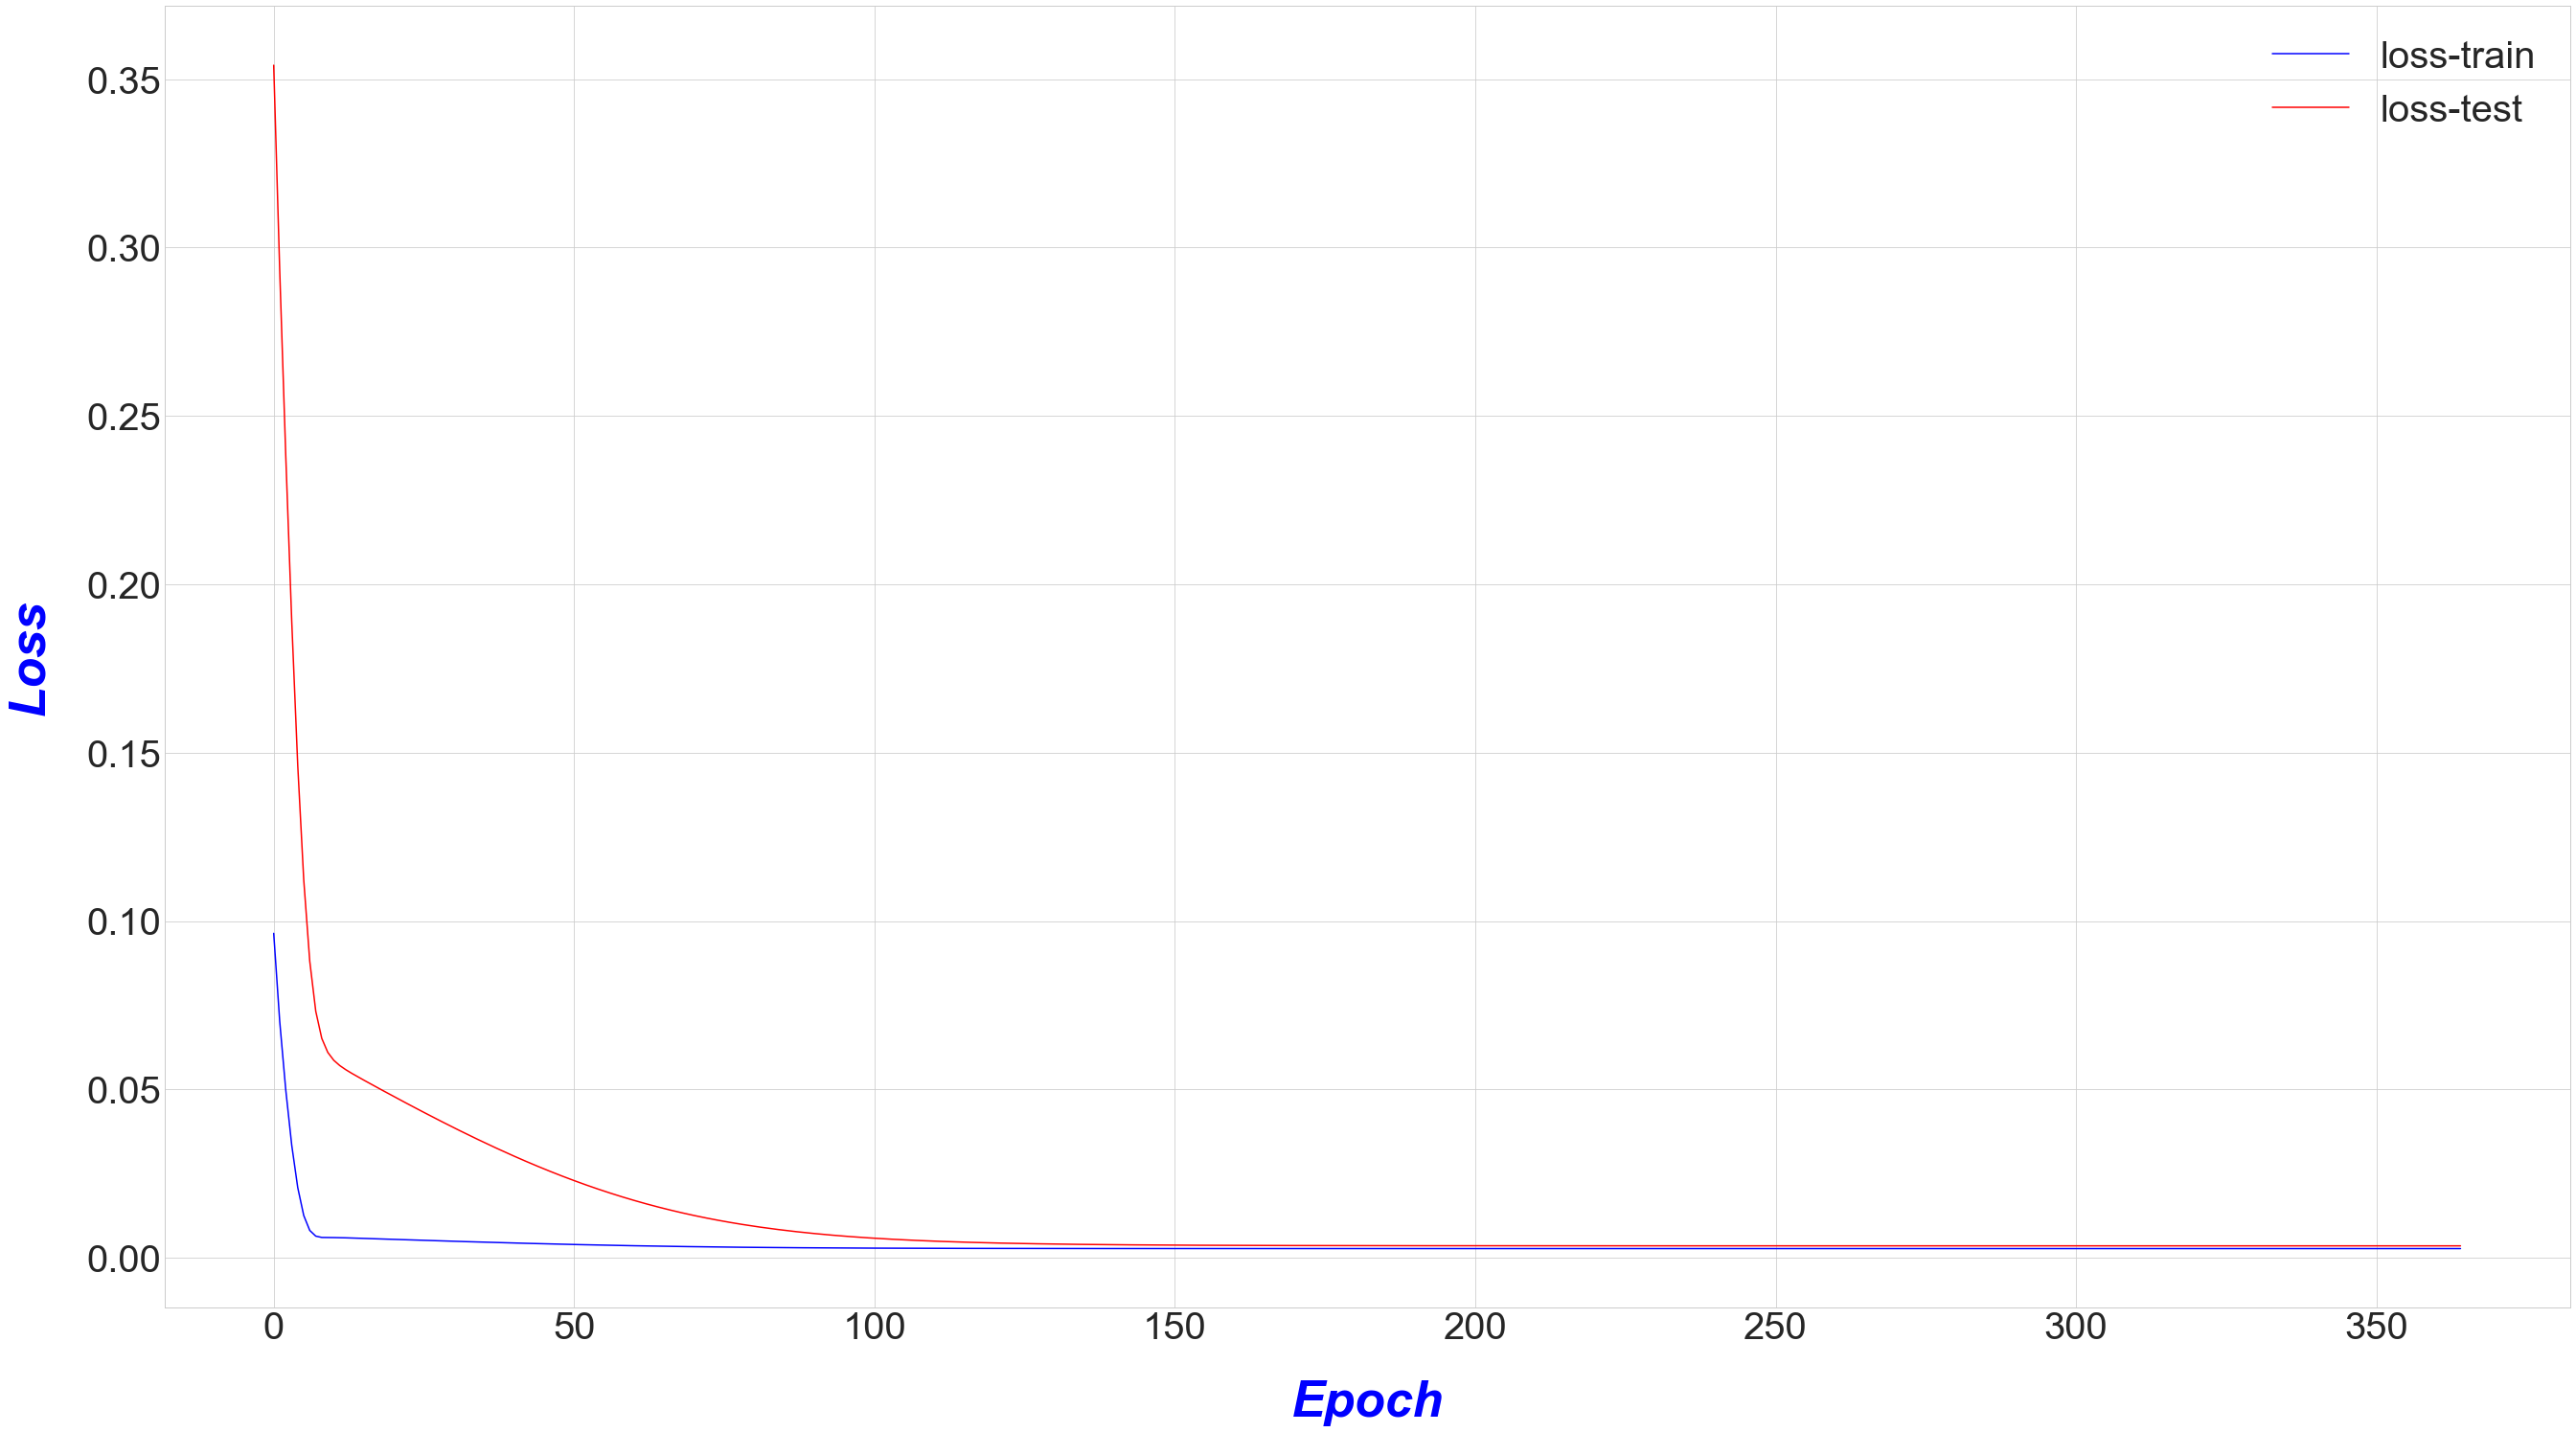

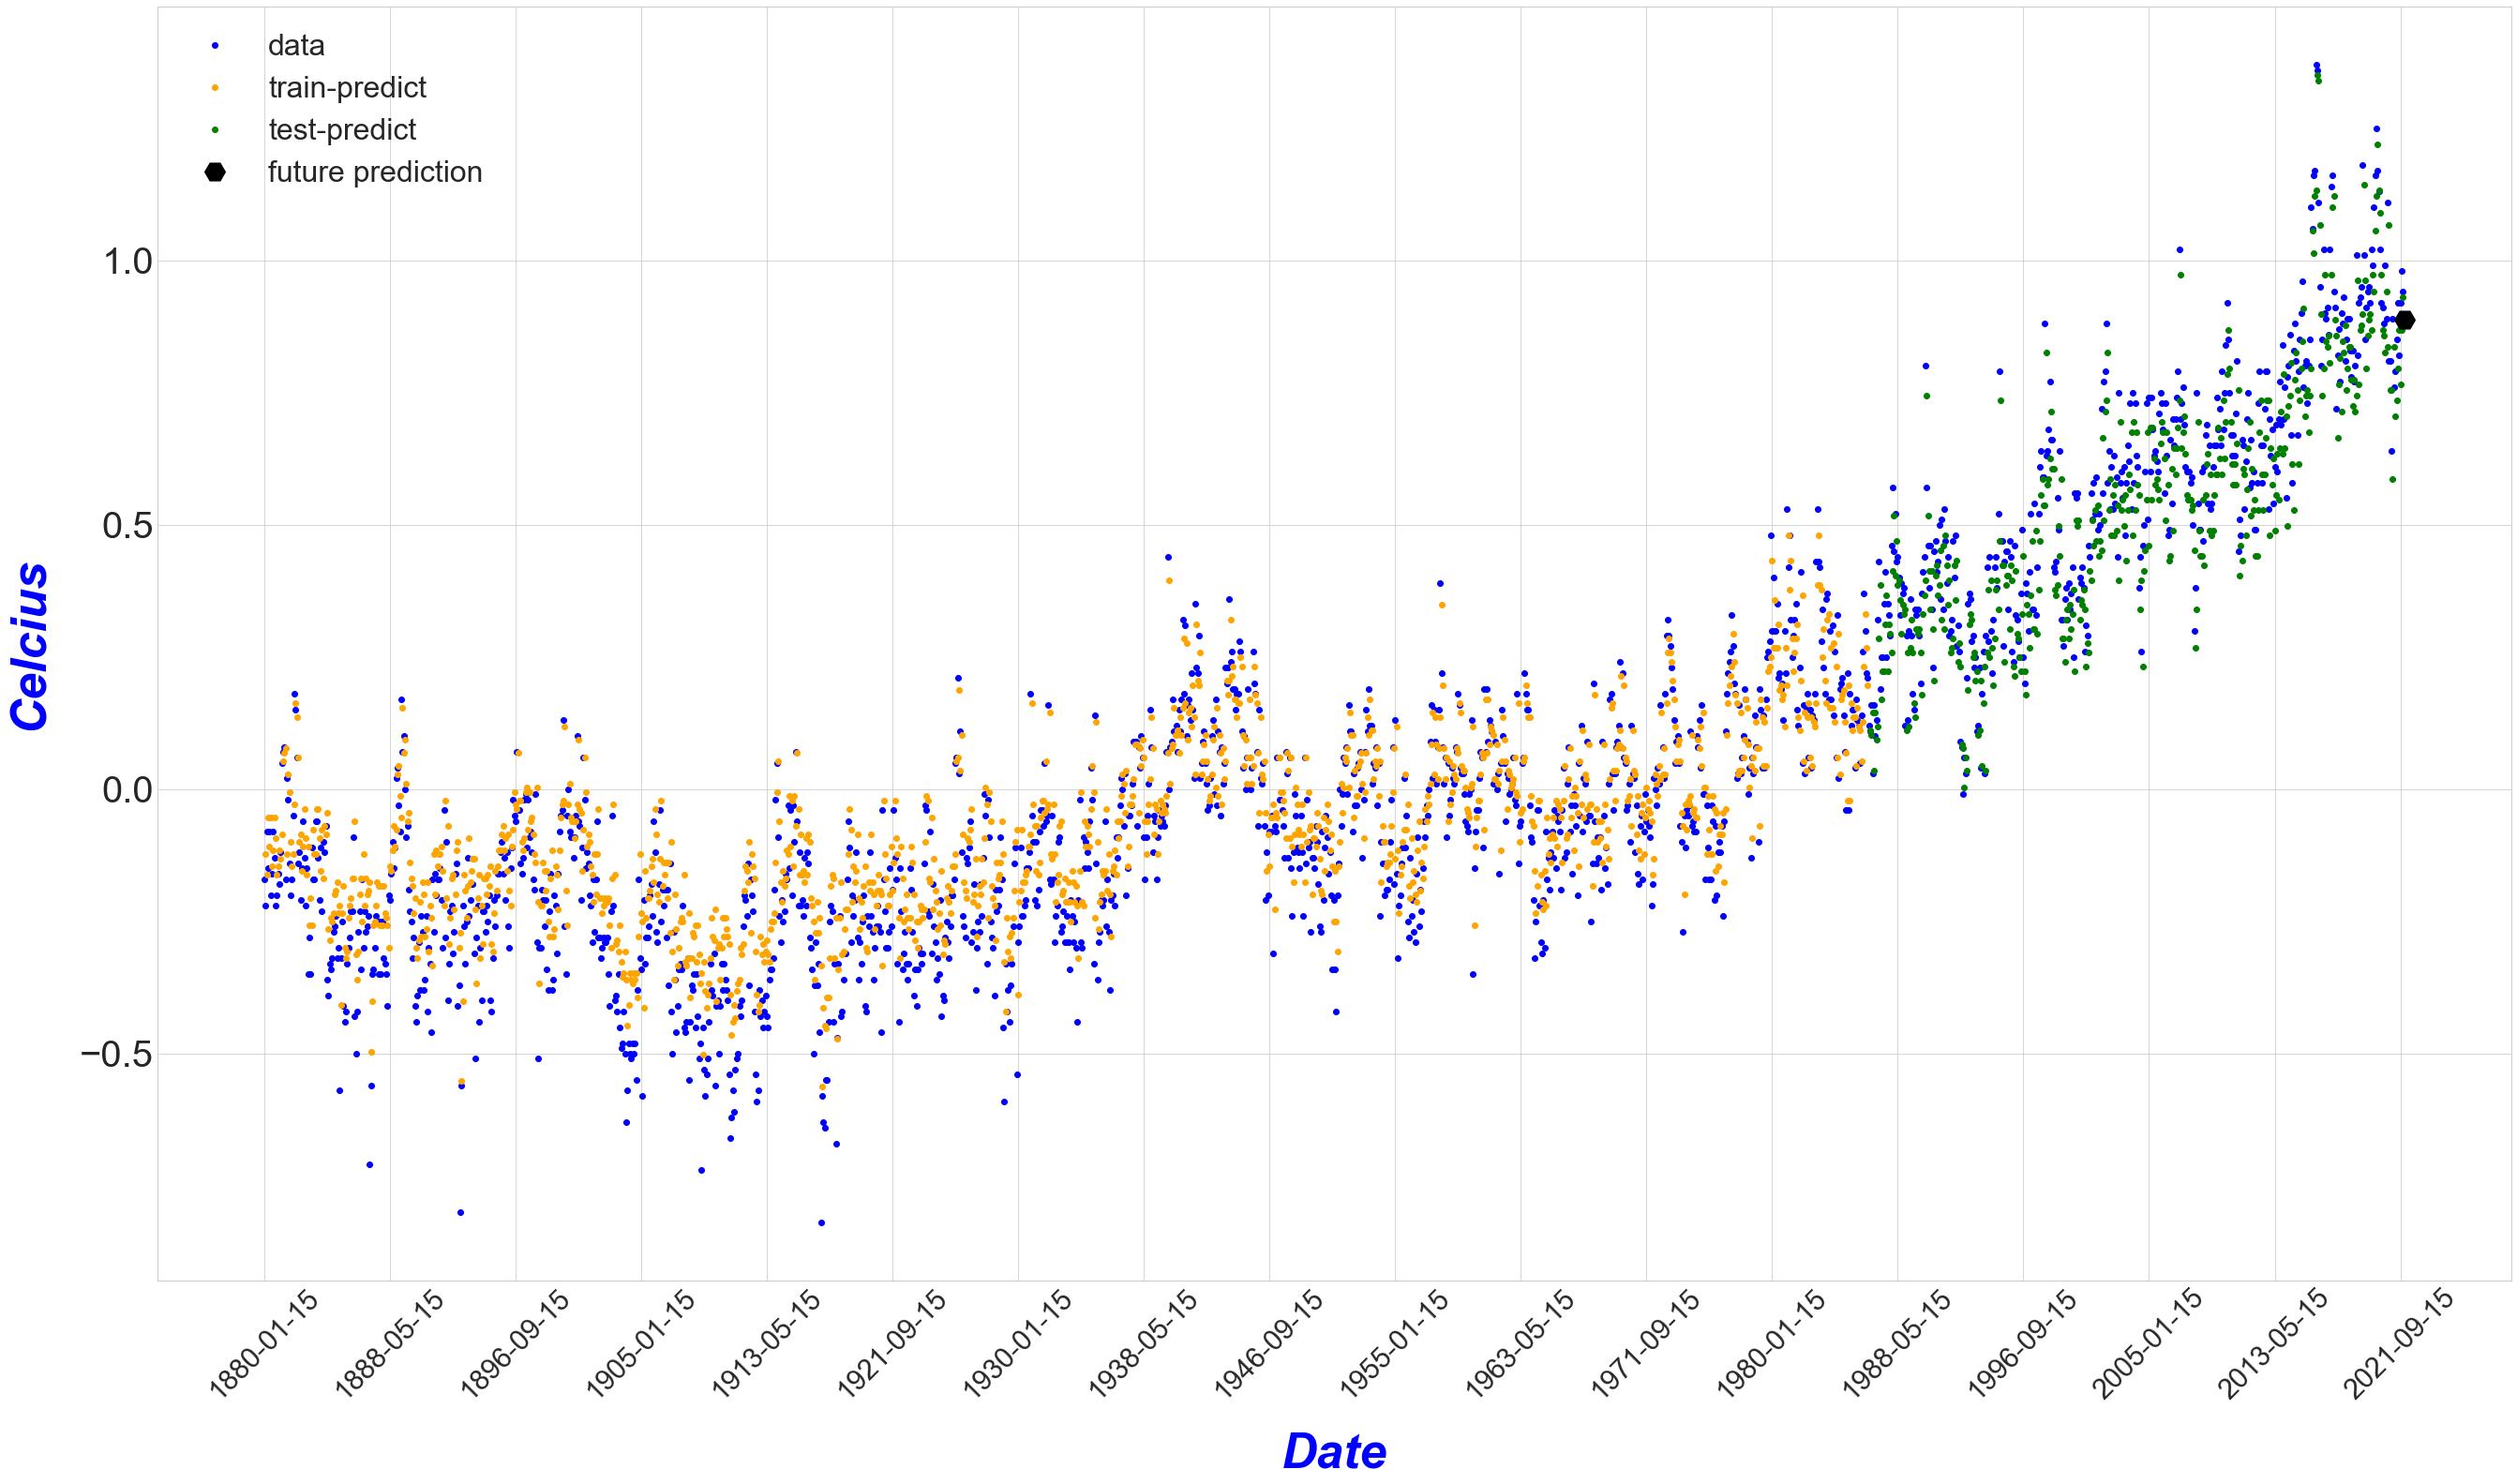

In [878]:
#
# Plot for bidirectional LSTM model
#

plt.style.use('seaborn-whitegrid')

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
testPredictPlot[len(trainPredict)+(look_back)+1:len(dataset), :] = testPredict   

futurePredictPlot = np.empty_like(dataset)
futurePredictPlot[:, :] = np.nan
futurePredictPlot = np.append(futurePredictPlot, future_prediction)

epochs = range(len(history_bidirectional_lstm.history['loss']))

#
# Plot Loss graph
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")

plt.plot(epochs, history_bidirectional_lstm.history['loss'], "b", label='loss-train')
plt.plot(epochs, history_bidirectional_lstm.history['val_loss'], "r", label='loss-test')

#plt.suptitle('LSTM Bidirectional Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam)', fontsize=60, weight='bold', style='italic', color='black')
#plt.title('LSTM Loss (learning-rate=' + str(lrate) + ')' + ', Train Score: %.3f RMSE' % (trainScore) + ', Test Score: %.2f RMSE' % (testScore), fontsize=50, weight='normal', style='italic', color='black', pad=30)
ax.legend(fontsize=40)
ax.tick_params(axis='both', labelsize=32)
ax.set_xlabel('Epoch', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.set_ylabel('Loss', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(True)
plt.savefig("./images/lstm-bidirectional-loss.png")
plt.show();

    
#
# Time prediction plot
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")
plt.plot(orig_x_axis, scaler.inverse_transform(dataset), 'bo', markersize=6, label="data")  # Blue
plt.plot(orig_x_axis, trainPredictPlot, 'o', color='orange', markersize=6, label='train-predict')  # Orange
plt.plot(orig_x_axis, testPredictPlot, 'go', markersize=6, label='test-predict')   # Green
plt.plot(future_x_axis, futurePredictPlot, 'kH', markersize=22, label='future prediction')

#plt.suptitle('LSTM Bidirectional Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam)', fontsize=60, weight='bold', style='italic', color='black')
#plt.title('LSTM Train, Test, Future Predictions - Future Prediction = %.4f C' % future_prediction[0][0], fontsize=50, weight='normal', style='italic', color='black', pad=38)

ax.legend(fontsize=32)
ax.tick_params(labelsize=20, width=20) #ax.tick_params(labelcolor='r', labelsize='medium', width=3)
ax.set_xlabel('Date', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.set_ylabel('Celcius', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.xaxis.set_major_locator(ticker.MaxNLocator(20))
ax.xaxis.set_minor_locator(ticker.MaxNLocator(40))
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=30)
plt.yticks(fontsize=40)
plt.grid(True)
plt.savefig("./images/lstm-bidirectional-plot.png")
plt.show();

## **Run the Stacked Bidirectional Model**

In [869]:
#
# Stacked, Bidirectional layer LSTM
#

tf.keras.backend.clear_session()

lrate = 0.00002
look_back = 1
batch_size = 1
loss_type = 'mean_squared_error'
num_epochs = 1000   # 200

history_stacked_bidirectional_lstm, lstm_stacked_bidirectional_model = create_stacked_bidirectional_lstm_model(trainX, trainY, testX, testY, lrate, loss_type, num_epochs, look_back, 1)
lstm_bidirectional_model.save('./models/lstm_bidirectional_model_1')
    
#
# Predictions
#
trainPredict = lstm_stacked_bidirectional_model.predict(trainX)
testPredict = lstm_stacked_bidirectional_model.predict(testX)
    
#
# Make next time period prediction
#
print("Last Entry:")
print(last_entry)
future_prediction = lstm_stacked_bidirectional_model.predict(last_entry)
print("Future Prediction scaled: " + str(future_prediction))
future_prediction = scaler.inverse_transform(future_prediction)
print("Future Prediction unscaled: " + str(future_prediction))

#
# Invert predictions back using the scalar
#
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform([testY])

#
# Calculate root mean squared error
#
#print()
trainScore = math.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

score_lstm = lstm_stacked_bidirectional_model.evaluate(testX, testY, verbose=1)
print("Model's Evaluation Score:")
print(score_lstm)

print('mean-squared-error:')
print(mean_squared_error(testY_orig[0], testPredict))

print('mean-absolute-error:')
print(mean_absolute_error(testY_orig[0], testPredict))

print('r2-score:')
print(r2_score(testY_orig[0], testPredict))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Bidirectional)      (None, 1, 32)             2304      
                                                                 
 layer2 (Bidirectional)      (None, 32)                6272      
                                                                 
 Output (Dense)              (None, 1)                 33        
                                                                 
Total params: 8,609
Trainable params: 8,609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1276/1276 - 6s - loss: 0.0744 - accuracy: 7.8370e-04 - mae: 0.2623 - mse: 0.0744 - val_loss: 0.2382 - val_accuracy: 0.0000e+00 - val_mae: 0.4766 - val_mse: 0.2382 - 6s/epoch - 5ms/step
Epoch 2/1000
1276/1276 - 2s - loss: 0.0219 - accuracy: 7.8370e-04 - mae: 0.1334 - mse: 0.0219 - val_loss: 0.0965 - val_a

INFO:tensorflow:Assets written to: ./models/lstm_bidirectional_model_1/assets


Last Entry:
[[[0.8036529]]]
Future Prediction scaled: [[0.77777016]]
Future Prediction unscaled: [[0.88331676]]
Train Score: 0.12 RMSE
Test Score: 0.13 RMSE
14/14 [==============================] - 1s 1ms/step - loss: 0.0035 - accuracy: 0.0024 - mae: 0.0480 - mse: 0.0035 
Model's Evaluation Score:
[0.003510098671540618, 0.002352941082790494, 0.04795249551534653, 0.003510098671540618]
mean-squared-error:
0.016834785498117778
mean-absolute-error:
0.10501597429469224
r2-score:
0.7361768874360837


## **Plot the Stacked Bidirectional Model**

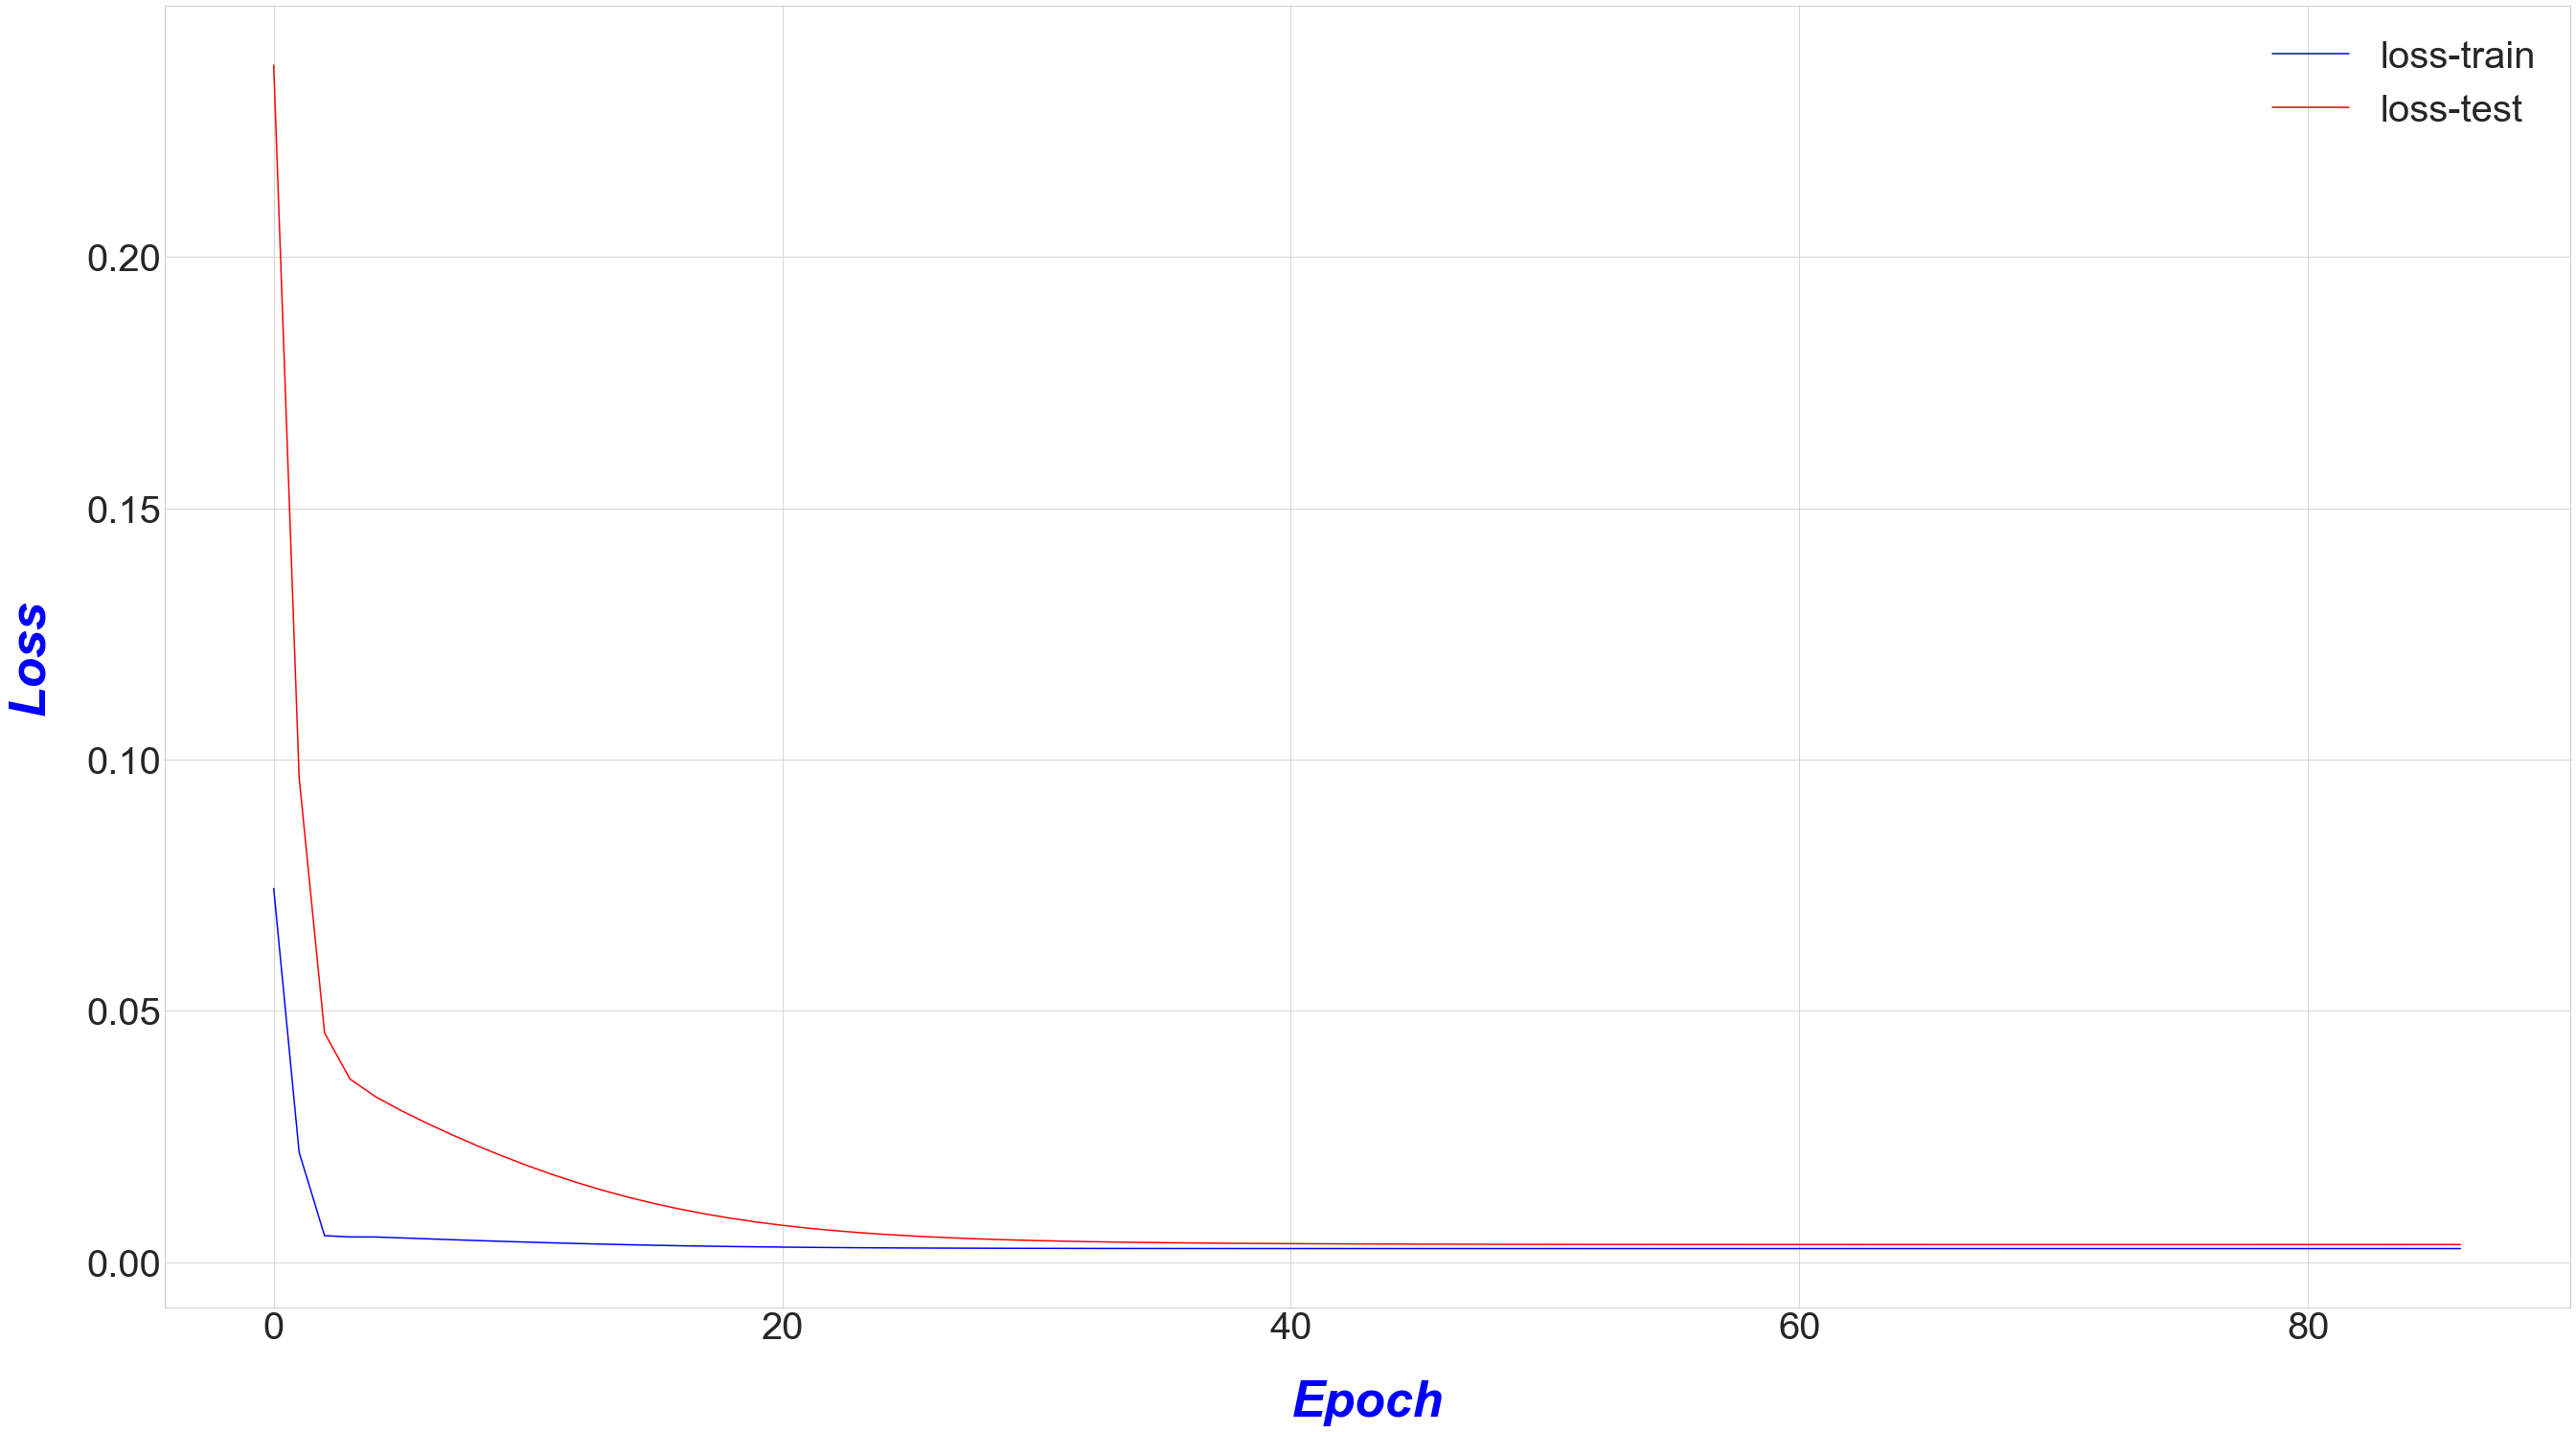

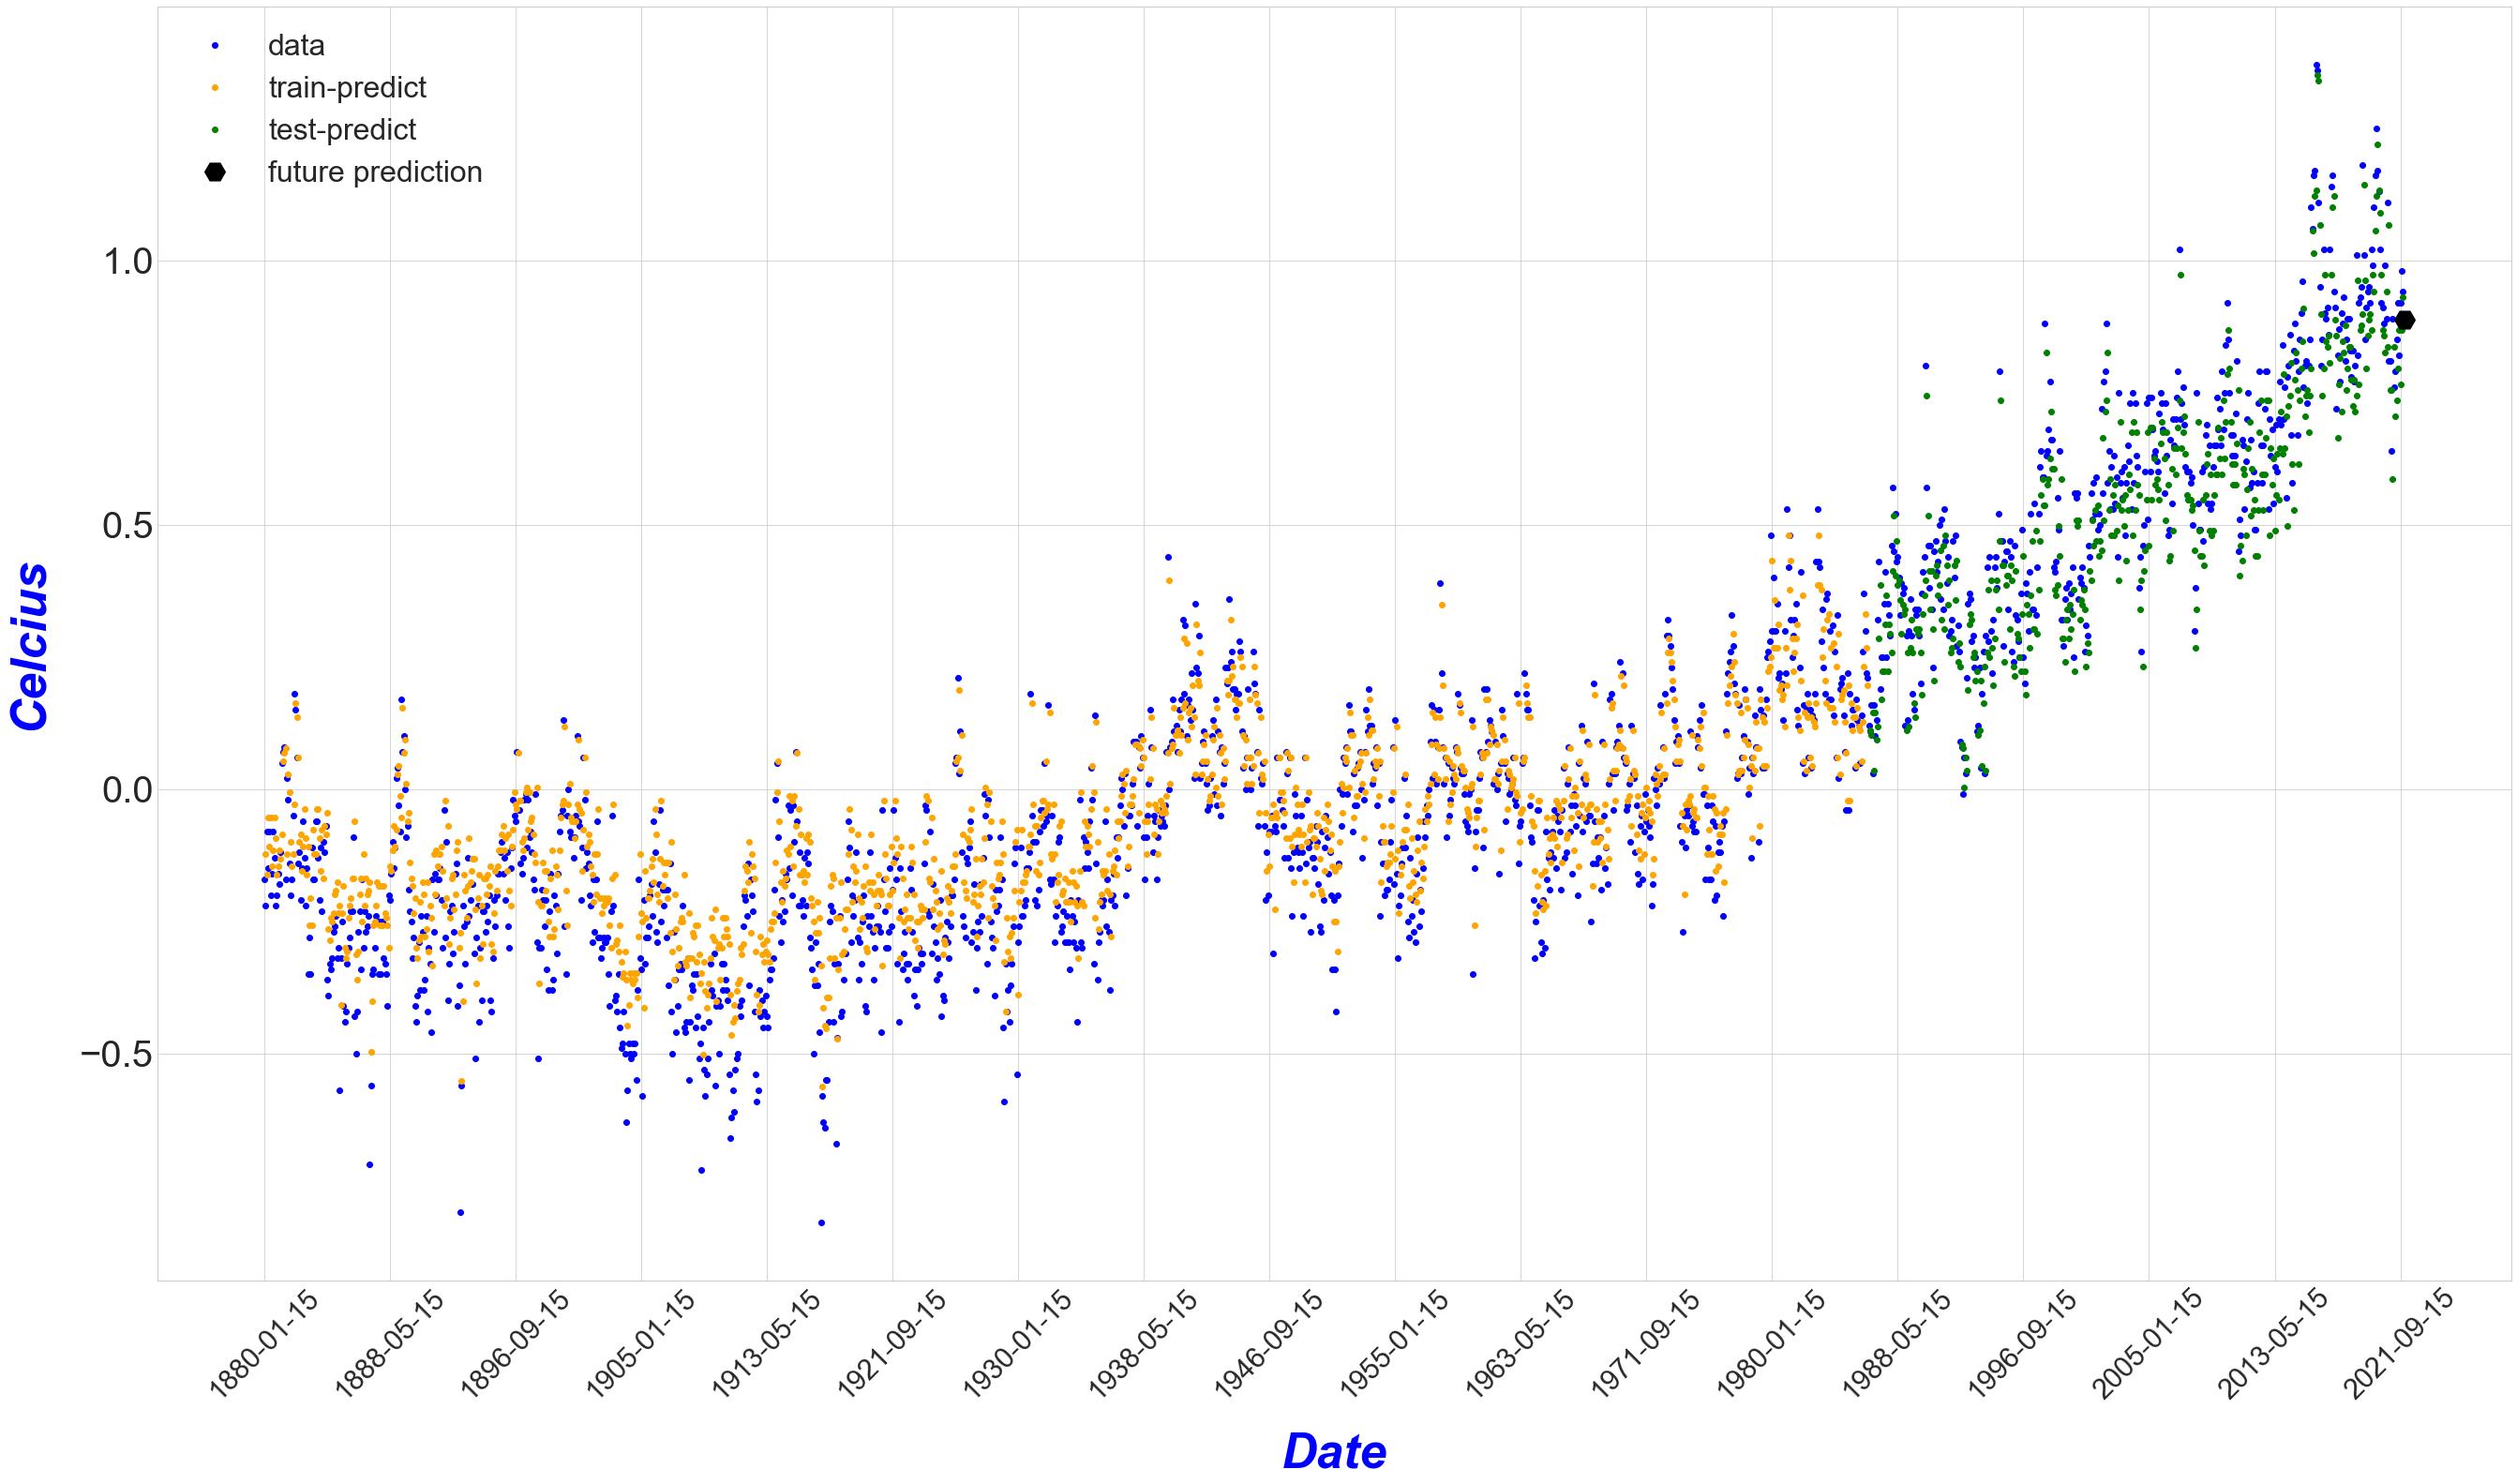

In [879]:
#
# Plot for bidirectional LSTM model
#

plt.style.use('seaborn-whitegrid')

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back)+1:len(dataset), :] = testPredict   

futurePredictPlot = np.empty_like(dataset)
futurePredictPlot[:, :] = np.nan
futurePredictPlot = np.append(futurePredictPlot, future_prediction)

epochs = range(len(history_stacked_bidirectional_lstm.history['loss']))

#
# Plot Loss graph
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")

plt.plot(epochs, history_stacked_bidirectional_lstm.history['loss'], "b", label='loss-train')
plt.plot(epochs, history_stacked_bidirectional_lstm.history['val_loss'], "r", label='loss-test')

#plt.suptitle('LSTM Stacked Bidirectional Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam, Epochs: 500)', fontsize=60, weight='bold', style='italic', color='black')
#plt.title('LSTM Loss (learning-rate=' + str(lrate) + ')' + ', Train Score: %.3f RMSE' % (trainScore) + ', Test Score: %.2f RMSE' % (testScore), fontsize=50, weight='normal', style='italic', color='black', pad=30)
ax.legend(fontsize=40)
ax.tick_params(axis='both', labelsize=32)
ax.set_xlabel('Epoch', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.set_ylabel('Loss', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(True)
plt.savefig("./images/lstm-stacked-bidirectional-loss.png")
plt.show();

    
#
# Time prediction plot
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")
plt.plot(orig_x_axis, scaler.inverse_transform(dataset), 'bo', markersize=6, label="data")  # Blue
plt.plot(orig_x_axis, trainPredictPlot, 'o', color='orange', markersize=6, label='train-predict')  # Orange
plt.plot(orig_x_axis, testPredictPlot, 'go', markersize=6, label='test-predict')   # Green
plt.plot(future_x_axis, futurePredictPlot, 'kH', markersize=22, label='future prediction')

#plt.suptitle('LSTM Stacked Bidirectional Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam, Epochs: 500)', fontsize=60, weight='bold', style='italic', color='black')
#plt.title('LSTM Train, Test, Future Predictions - Future Prediction = %.4f C' % future_prediction[0][0], fontsize=50, weight='normal', style='italic', color='black', pad=38)

ax.legend(fontsize=32)
ax.tick_params(labelsize=20, width=20) #ax.tick_params(labelcolor='r', labelsize='medium', width=3)
ax.set_xlabel('Date', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.set_ylabel('Celcius', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.xaxis.set_major_locator(ticker.MaxNLocator(20))
ax.xaxis.set_minor_locator(ticker.MaxNLocator(40))
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=30)
plt.yticks(fontsize=40)
plt.grid(True)
plt.savefig("./images/lstm-stacked-bidirectional-plot.png")
plt.show();

<br>
<br>
<br>

# **Create Main Climate Change Dataframe**
### Using all dataset csv files

In [627]:
#
# Apply method for each dataset's dataframe
#
def update_master_df(row):
   
    global df_main
    
    if row['Country Code'] != 'WLD':
        return
    
    #country = row['Country Code']
    code = row['Indicator Code']
    
    d = []
    
    for y in range(1960, 2021, 1):
        if str(y) in row:
            d.append(row[str(y)])
        else:
            d.append(float("NaN"))
    
    df_main[code] = d

      

file_names = [
    'API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_3053855.csv',     # Access to electricity (% of population) EG.ELC.ACCS.ZS
    'API_AG.LND.AGRI.ZS_DS2_en_csv_v2_3052884.csv',     # Agricultural land (% of land area) AG.LND.AGRI.ZS
    'API_AG.LND.ARBL.ZS_DS2_en_csv_v2_3054826.csv',     # Arable land (% of land area) AG.LND.ARBL.ZS
    'API_EN.ATM.CO2E.PC_DS2_en_csv_v2_3053008.csv',     # CO2 emissions (metric tons per capita) EN.ATM.CO2E.PC
    'API_AG.YLD.CREL.KG_DS2_en_csv_v2_3053734.csv',     # Cereal yield (kg per hectare) AG.YLD.CREL.KG
    'API_EG.USE.ELEC.KH.PC_DS2_en_csv_v2_3052822.csv',  # Electric power consumption (kWh per capita) EG.USE.ELEC.KH.PC
    'API_AG.LND.FRST.ZS_DS2_en_csv_v2_3052585.csv',     # Forest area (% of land area) AG.LND.FRST.ZS
    'API_AG.LND.EL5M.ZS_DS2_en_csv_v2_3057029.csv',     # Land area where elevation is below 5 meters (% of total land area) AG.LND.EL5M.ZS
    'API_SH.DYN.MORT_DS2_en_csv_v2_3058030.csv',        # Mortality rate, under-5 (per 1,000 live births) SH.DYN.MORT
    'API_SP.POP.GROW_DS2_en_csv_v2_3052790.csv',        # Population growth (annual %) SP.POP.GROW
    'API_EN.POP.EL5M.ZS_DS2_en_csv_v2_3057452.csv',     # Population living in areas where elevation is below 5 meters (% of total population) EN.POP.EL5M.ZS
    'API_SI.POV.DDAY_DS2_en_csv_v2_3055766.csv',        # Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population) SI.POV.DDAY
    'API_SE.PRM.CMPT.ZS_DS2_en_csv_v2_3053767.csv',     # Primary completion rate, total (% of relevant age group) SE.PRM.CMPT.ZS
    'API_EG.FEC.RNEW.ZS_DS2_en_csv_v2_3053509.csv',     # Renewable energy consumption (% of total final energy consumption) EG.FEC.RNEW.ZS
    'API_SP.URB.TOTL_DS2_en_csv_v2_3058363.csv',        # Urban population SP.URB.TOTL
    'API_NV.AGR.TOTL.ZS_DS2_en_csv_v2_3052981.csv',     # Agriculture, forestry, and fishing, value added (% of GDP) NV.AGR.TOTL.ZS
    'API_EN.ATM.CO2E.KT_DS2_en_csv_v2_3052647.csv',     # CO2 emissions (kt) EN.ATM.CO2E.KT
    'API_EG.USE.PCAP.KG.OE_DS2_en_csv_v2_3052915.csv',  # Energy use (kg of oil equivalent per capita) EG.USE.PCAP.KG.OE
    'API_AG.LND.FRST.K2_DS2_en_csv_v2_3054052.csv',     # Forest area (sq. km) AG.LND.FRST.K2
    'API_EN.ATM.METH.KT.CE_DS2_en_csv_v2_3052859.csv',  # Methane emissions (kt of CO2 equivalent) EN.ATM.METH.KT.CE
    'API_EN.ATM.NOXE.KT.CE_DS2_en_csv_v2_3054894.csv',  # Nitrous oxide emissions (thousand metric tons of CO2 equivalent) EN.ATM.NOXE.KT.CE
    'API_EN.URB.MCTY.TL.ZS_DS2_en_csv_v2_3053950.csv',  # Population in urban agglomerations of more than 1 million (% of total population) EN.URB.MCTY.TL.ZS
    'API_SP.POP.TOTL_DS2_en_csv_v2_3052518.csv',        # Population, total SP.POP.TOTL
    'API_SH.STA.MALN.ZS_DS2_en_csv_v2_3058087.csv',     # Prevalence of underweight, weight for age (% of children under 5) SH.STA.MALN.ZS
    'API_EG.ELC.RNEW.ZS_DS2_en_csv_v2_3054878.csv',     # Renewable electricity output (% of total electricity output) EG.ELC.RNEW.ZS
    'API_SE.ENR.PRSC.FM.ZS_DS2_en_csv_v2_3057870.csv',  # School enrollment, primary and secondary (gross), gender parity index (GPI) SE.ENR.PRSC.FM.ZS
    'API_EN.ATM.GHGT.KT.CE_DS2_en_csv_v2_3052850.csv',  # Total greenhouse gas emissions (kt of CO2 equivalent) EN.ATM.GHGT.KT.CE
    'API_SP.URB.TOTL.IN.ZS_DS2_en_csv_v2_3053985.csv'   # Urban population (% of total population) SP.URB.TOTL.IN.ZS
]


#
# Main dataframe to work off of
#

df_main = pd.DataFrame(columns=['year'])
df_main['year'] = [
    1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
    1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
    1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
    1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
    2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
    2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
    2020
]


#
# Loop through each dataset and add it to the main dataframe
#
c = 0
df_collection = {}
for f in file_names:
    _df = pd.read_csv(data_dir + f)
    _df.drop(columns=['Country Name', 'Indicator Name'], inplace=True)
    _df.drop(_df.columns[_df.columns.str.contains('unnamed', case = False)], axis = 1, inplace = True)
    df_collection[c] = _df
    _df.apply(update_master_df, axis=1)             
    c += 1

#pd.set_option("display.max_rows", None, "display.max_columns", None)
df_main.head(65)  

,year,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,AG.LND.EL5M.ZS,SH.DYN.MORT,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
0,1960,NaN,NaN,NaN,3.121158,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.130853,3.032156e+09,NaN,NaN,NaN,NaN,33.617972
1,1961,NaN,35.965095,9.656792,3.068090,1428.405939,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.400146,3.071596e+09,NaN,NaN,NaN,NaN,34.115490
2,1962,NaN,36.044180,9.668757,3.114839,1518.828776,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.589890,3.124561e+09,NaN,NaN,NaN,NaN,34.557149
3,1963,NaN,36.146651,9.756626,3.221195,1583.640114,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.729545,3.189656e+09,NaN,NaN,NaN,NaN,34.943734
4,1964,NaN,36.236356,9.785195,3.324046,1585.371387,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.884439,3.255146e+09,NaN,NaN,NaN,NaN,35.336154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2016,87.714456,36.701221,10.764754,4.436759,4009.231276,NaN,30.716421,NaN,41.3,...,39958245.9,8068580.0,2934600.0,23.538567,7.424485e+09,13.732595,NaN,1.00006,44550150.0,54.370833
57,2017,88.602034,37.008413,10.831252,4.441309,4114.052902,NaN,NaN,NaN,40.0,...,NaN,8137390.0,2986520.0,23.765917,7.509410e+09,13.416059,NaN,0.99759,45117640.0,54.823831
58,2018,89.419014,36.903521,10.825170,4.483524,4070.667048,NaN,NaN,NaN,38.8,...,NaN,8174420.0,2984340.0,24.008219,7.592476e+09,13.133182,NaN,0.98576,45873850.0,55.271710
59,2019,90.084031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.7,...,NaN,NaN,NaN,24.216891,7.673345e+09,12.864292,NaN,0.98637,NaN,55.714433


In [628]:
#
# Add the beginning years (1880 to 1959) for which there are temperature data but no data for the coarse datasets
#

for i in range(1959, 1879, -1):
    df_main.loc[-1] = [i, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
    df_main.index = df_main.index + 1
    df_main = df_main.sort_index()

In [629]:
#
# Make 12 copies for each row. The termperature dataset comes in 12 data points per year and the other datasets provide one data point per year
# Just copy the row 12 times as a best approximation
#

df_main = df_main.loc[df_main.index.repeat(12)]
df_main = df_main.sort_index()
df_main.reset_index(drop=True, inplace=True)

In [630]:
#
# Show that there are 12 rows for 1880
#

df_main.head(13)

,year,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,AG.LND.EL5M.ZS,SH.DYN.MORT,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
0,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [631]:
df_main.tail(13)

,year,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,AG.LND.EL5M.ZS,SH.DYN.MORT,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
1679,2019.0,90.084031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.7,...,NaN,NaN,NaN,24.216891,7.673345e+09,12.864292,NaN,0.98637,NaN,55.714433
1680,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1681,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1682,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1683,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1684,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1685,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1686,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1687,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1688,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401


In [632]:
#
# Convert all 'year' values from 1980.0 to '1980-01-15', etc
# Use the index mod by 12 to determine what month it should be. The temperature day is always set to 15 in the temperature dataset
#

df_main['year'] = df_main['year'].astype('int64')

def fix_dates(row):
    idx = int(row.name)
    month = (idx % 12) + 1
    month = f'{month:02d}'
    row['year'] = str(int(row['year'])) + '-' + str(month) + '-15'
    # print(row.name)
    return row

new_df = df_main.apply(fix_dates, axis=1)

# Rename year column to Day (to join on with other dataframe)
new_df.rename(columns={'year': 'Day'}, inplace=True)

In [633]:
new_df.head(13)

,Day,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,AG.LND.EL5M.ZS,SH.DYN.MORT,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
0,1880-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1880-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1880-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1880-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1880-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1880-06-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1880-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1880-08-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1880-09-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1880-10-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [634]:
new_df.tail(13)

,Day,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,AG.LND.EL5M.ZS,SH.DYN.MORT,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
1679,2019-12-15,90.084031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.7,...,NaN,NaN,NaN,24.216891,7.673345e+09,12.864292,NaN,0.98637,NaN,55.714433
1680,2020-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1681,2020-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1682,2020-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1683,2020-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1684,2020-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1685,2020-06-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1686,2020-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1687,2020-08-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1688,2020-09-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401


In [635]:
#
# Fill in the missing rows at the end where the datasets do not have the same length as the temperature datasets
# (Temperature goes up to Nov 2021, other datasets end at Dec 2020)
#

data_values=new_df.tail(1).values

data_values[0][0] = '2021-01-15'
new_df.loc[len(new_df.index)] = data_values[0]
data_values[0][0] = '2021-02-15'
new_df.loc[len(new_df.index)] = data_values[0]
data_values[0][0] = '2021-03-15'
new_df.loc[len(new_df.index)] = data_values[0]
data_values[0][0] = '2021-04-15'
new_df.loc[len(new_df.index)] = data_values[0]
data_values[0][0] = '2021-05-15'
new_df.loc[len(new_df.index)] = data_values[0]
data_values[0][0] = '2021-06-15'
new_df.loc[len(new_df.index)] = data_values[0]
data_values[0][0] = '2021-07-15'
new_df.loc[len(new_df.index)] = data_values[0]
data_values[0][0] = '2021-08-15'
new_df.loc[len(new_df.index)] = data_values[0]
data_values[0][0] = '2021-09-15'
new_df.loc[len(new_df.index)] = data_values[0]
data_values[0][0] = '2021-10-15'
new_df.loc[len(new_df.index)] = data_values[0]
data_values[0][0] = '2021-11-15'
new_df.loc[len(new_df.index)] = data_values[0]

In [637]:
new_df.tail(12)

,Day,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,AG.LND.EL5M.ZS,SH.DYN.MORT,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
1691,2020-12-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1692,2021-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1693,2021-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1694,2021-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1695,2021-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1696,2021-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1697,2021-06-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1698,2021-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1699,2021-08-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1700,2021-09-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401


In [638]:
# These numbers should be equal (the same as the original dataframe in length)

print("These two datafame lengths should now be equal so they can be joined:")
print(len(new_df))
print(len(master_df))

These two datafame lengths should now be equal so they can be joined:
1703
1703


In [639]:
#
# Create the final dataframe by merging the original saved at the beginning and the newly dataframe just created
#

final_df = pd.merge(master_df, new_df, on="Day")
final_df

,Day,world_air_temperature_anomaly,world_sea_temperature_anomaly,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
0,1880-01-15,-0.17,-0.2283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1880-02-15,-0.22,-0.1353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1880-03-15,-0.08,-0.0102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1880-04-15,-0.15,-0.1158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1880-05-15,-0.08,-0.3387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1698,2021-07-15,0.92,0.7308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1699,2021-08-15,0.82,0.7242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1700,2021-09-15,0.92,0.7127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401
1701,2021-10-15,0.98,0.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.434215,7.752841e+09,12.597688,NaN,NaN,NaN,56.150401


## Correlation Matrices
#### Look at the correlation of the features to the target column: 'world_air_temperature_anomaly'

In [640]:
#df_pearson = final_df.corr(method='pearson')
#df_pearson

In [641]:
#df_kendall = final_df.corr(method='kendall')
#df_kendall

In [642]:
df_spearman = final_df.corr(method='spearman')
df_spearman

,world_air_temperature_anomaly,world_sea_temperature_anomaly,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,AG.LND.EL5M.ZS,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
world_air_temperature_anomaly,1.000000,0.928424,0.721239,-0.056537,0.722215,0.323415,0.896278,0.863540,-0.755347,-0.178574,...,-0.752921,0.882082,0.573328,0.911990,0.911990,-0.757274,0.082029,0.896582,0.777605,0.911990
world_sea_temperature_anomaly,0.928424,1.000000,0.643318,-0.050203,0.752323,0.293484,0.915380,0.881474,-0.697382,-0.121172,...,-0.695014,0.894406,0.539548,0.928365,0.928365,-0.729627,0.058226,0.914223,0.759614,0.928365
EG.ELC.ACCS.ZS,0.721239,0.643318,1.000000,-0.581818,0.651948,0.835065,0.949351,0.968137,-0.980702,-1.000000,...,-0.980702,0.985714,0.977922,0.987578,0.987578,-0.983459,0.688338,0.945793,0.983117,0.987578
AG.LND.AGRI.ZS,-0.056537,-0.050203,-0.581818,1.000000,0.250361,0.441201,-0.012027,-0.609584,0.597680,-0.500000,...,0.605617,-0.572653,-0.090714,-0.031468,-0.031468,0.382456,-0.219145,-0.613469,-0.371327,-0.031468
AG.LND.ARBL.ZS,0.722215,0.752323,0.651948,0.250361,1.000000,0.396721,0.822757,0.593798,-0.143468,-0.500000,...,-0.141636,0.717857,0.570204,0.818020,0.818020,-0.829825,0.752479,0.688776,0.580816,0.818020
EN.ATM.CO2E.PC,0.323415,0.293484,0.835065,0.441201,0.396721,1.000000,0.363253,-0.159972,-0.861416,-0.500000,...,-0.857753,-0.006633,0.570918,0.395675,0.395675,-0.831579,0.262222,0.008980,0.385204,0.395675
AG.YLD.CREL.KG,0.896278,0.915380,0.949351,-0.012027,0.822757,0.363253,1.000000,0.988865,-0.972527,0.500000,...,-0.970696,0.979592,0.603469,0.995447,0.995447,-0.982456,0.212991,0.983163,0.825918,0.995447
EG.USE.ELEC.KH.PC,0.863540,0.881474,0.968137,-0.609584,0.593798,-0.159972,0.988865,1.000000,-0.996154,0.500000,...,-0.994615,0.973362,0.460747,0.998450,0.998450,-0.985714,0.129231,0.991402,0.770965,0.998450
AG.LND.FRST.ZS,-0.755347,-0.697382,-0.980702,0.597680,-0.143468,-0.861416,-0.972527,-0.996154,1.000000,-0.500000,...,0.999389,-0.906593,-0.985348,-0.999389,-0.999389,1.000000,-0.237607,-0.998779,-0.998168,-0.999389
AG.LND.EL5M.ZS,-0.178574,-0.121172,-1.000000,-0.500000,-0.500000,-0.500000,0.500000,0.500000,-0.500000,1.000000,...,-0.500000,-0.500000,0.500000,0.500000,0.500000,1.000000,-0.500000,0.500000,0.500000,0.500000


In [643]:
#
# Setup X-axis labels for plot and drop Day column so that MinMaxScaler can be used (remove string columns)
#
# NOTE: Call MinMaxScaler BEFORE fillna with -1 !!!
#

# Test to drop the beginning n rows to compare prediction results - currently OFF
#num_rows_to_drop = 960

orig_x_axis = final_df['Day'].copy(deep=True)

#orig_x_axis = orig_x_axis[num_rows_to_drop:]

# Add the future prediction's x-axis label 
future_x_axis = orig_x_axis.append(pd.Series(['2021-12-15']))
future_x_axis.reset_index(drop=True, inplace=True)

final_df.drop('Day', axis=1, inplace=True)

In [644]:
future_x_axis

0       1880-01-15
1       1880-02-15
2       1880-03-15
3       1880-04-15
4       1880-05-15
           ...    
1699    2021-08-15
1700    2021-09-15
1701    2021-10-15
1702    2021-11-15
1703    2021-12-15
Length: 1704, dtype: object

In [645]:
#
# Save orig feature column BEFORE MinMaxScalar so it can be easily plotted without inverse-scaling
#

orig_plot_data = final_df['world_air_temperature_anomaly'].copy(deep=True).values

In [646]:
#
# READY to scale the dataset!
#

np.random.seed(7)
scaler = MinMaxScaler(feature_range=(0, 1))
final_df[final_df.columns] = scaler.fit_transform(final_df[final_df.columns])

#
# Create a new scaler that can be used for a ONE COLUMN numpy array
# The initial data was scaled by all columns so there are 31 values for min_, scale_, etc
# We only need the first values to descale the output values
#

# The first min_ and scale_ values from the original MinMaxScaler
new_scaler = MinMaxScaler()
new_scaler.min_, new_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

In [647]:
#
# Forward fill the end of each column to give some values for 2021 that are missing from the coarse datasets
# NOTE: Leaving this step out reduces the final 12 test values - best to keep it in if the data is missing
#

final_df.fillna(method='ffill', inplace=True)

# See if correlation changed after MinMaxScaler
#df_spearman = final_df.corr(method='spearman')
#df_spearman

In [648]:
#
# Fill in all NaN values with -1 so that these values can be masked during the model fit
#

final_df.fillna(value=-1, inplace=True)

In [649]:
#final_df.drop(index=final_df.index[:num_rows_to_drop], axis=0, inplace=True)
#final_df.head(961)

In [650]:
#
# Delete column 'world_sea_temperature_anomaly' ??? - Leave it in since it does have high correlation with the target
#

#final_df.drop(['world_sea_temperature_anomaly'], axis=1, inplace=True)

In [651]:
final_df.reset_index(drop=True, inplace=True)
final_df.head()

,world_air_temperature_anomaly,world_sea_temperature_anomaly,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,AG.LND.EL5M.ZS,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
0,0.296804,0.330878,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0.273973,0.389424,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,0.337900,0.468178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0.305936,0.401700,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0.337900,0.261379,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [652]:
print("Final Columns:")
final_df.columns

Final Columns:


Index(['world_air_temperature_anomaly', 'world_sea_temperature_anomaly',
       'EG.ELC.ACCS.ZS', 'AG.LND.AGRI.ZS', 'AG.LND.ARBL.ZS', 'EN.ATM.CO2E.PC',
       'AG.YLD.CREL.KG', 'EG.USE.ELEC.KH.PC', 'AG.LND.FRST.ZS',
       'AG.LND.EL5M.ZS', 'SH.DYN.MORT', 'SP.POP.GROW', 'EN.POP.EL5M.ZS',
       'SI.POV.DDAY', 'SE.PRM.CMPT.ZS', 'EG.FEC.RNEW.ZS', 'SP.URB.TOTL',
       'NV.AGR.TOTL.ZS', 'EN.ATM.CO2E.KT', 'EG.USE.PCAP.KG.OE',
       'AG.LND.FRST.K2', 'EN.ATM.METH.KT.CE', 'EN.ATM.NOXE.KT.CE',
       'EN.URB.MCTY.TL.ZS', 'SP.POP.TOTL', 'SH.STA.MALN.ZS', 'EG.ELC.RNEW.ZS',
       'SE.ENR.PRSC.FM.ZS', 'EN.ATM.GHGT.KT.CE', 'SP.URB.TOTL.IN.ZS'],
      dtype='object')

In [654]:
# There should be NO NaN values anywhere in the dataframe
# Non-Null Count should all be 1703

final_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1703 entries, 0 to 1702
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   world_air_temperature_anomaly  1703 non-null   float64
 1   world_sea_temperature_anomaly  1703 non-null   float64
 2   EG.ELC.ACCS.ZS                 1703 non-null   float64
 3   AG.LND.AGRI.ZS                 1703 non-null   float64
 4   AG.LND.ARBL.ZS                 1703 non-null   float64
 5   EN.ATM.CO2E.PC                 1703 non-null   float64
 6   AG.YLD.CREL.KG                 1703 non-null   float64
 7   EG.USE.ELEC.KH.PC              1703 non-null   float64
 8   AG.LND.FRST.ZS                 1703 non-null   float64
 9   AG.LND.EL5M.ZS                 1703 non-null   float64
 10  SH.DYN.MORT                    1703 non-null   float64
 11  SP.POP.GROW                    1703 non-null   float64
 12  EN.POP.EL5M.ZS                 1703 non-null   f

In [655]:
#
# Create a seperate Series for each of the dataframe's columns
#

col1 = final_df['world_air_temperature_anomaly'].values
col2 = final_df['world_sea_temperature_anomaly'].values

col3 = final_df['EG.ELC.ACCS.ZS'].values
col4 = final_df['AG.LND.AGRI.ZS'].values
col5 = final_df['AG.LND.ARBL.ZS'].values
col6 = final_df['EN.ATM.CO2E.PC'].values

col7 = final_df['AG.YLD.CREL.KG'].values
col8 = final_df['EG.USE.ELEC.KH.PC'].values
col9 = final_df['AG.LND.FRST.ZS'].values

col10 = final_df['AG.LND.EL5M.ZS'].values
col11 = final_df['SH.DYN.MORT'].values
col12 = final_df['SP.POP.GROW'].values
col13 = final_df['EN.POP.EL5M.ZS'].values

col14 = final_df['SI.POV.DDAY'].values
col15 = final_df['SE.PRM.CMPT.ZS'].values
col16 = final_df['EG.FEC.RNEW.ZS'].values
col17 = final_df['SP.URB.TOTL'].values

col18 = final_df['NV.AGR.TOTL.ZS'].values
col19 = final_df['EN.ATM.CO2E.KT'].values
col20 = final_df['EG.USE.PCAP.KG.OE'].values

col21 = final_df['AG.LND.FRST.K2'].values
col22 = final_df['EN.ATM.METH.KT.CE'].values
col23 = final_df['EN.ATM.NOXE.KT.CE'].values

col24 = final_df['EN.URB.MCTY.TL.ZS'].values
col25 = final_df['SP.POP.TOTL'].values
col26 = final_df['SH.STA.MALN.ZS'].values
col27 = final_df['EG.ELC.RNEW.ZS'].values

col28 = final_df['SE.ENR.PRSC.FM.ZS'].values
col29 = final_df['EN.ATM.GHGT.KT.CE'].values
col30 = final_df['SP.URB.TOTL.IN.ZS'].values

In [656]:
#
# Reshape all of the column Series
#

col1 = col1.reshape((len(col1), 1))
col2 = col2.reshape((len(col2), 1))
col3 = col3.reshape((len(col3), 1))
col4 = col4.reshape((len(col4), 1))
col5 = col5.reshape((len(col5), 1))
col6 = col6.reshape((len(col6), 1))
col7 = col7.reshape((len(col7), 1))
col8 = col8.reshape((len(col8), 1))
col9 = col9.reshape((len(col9), 1))
col10 = col10.reshape((len(col10), 1))
col11 = col11.reshape((len(col11), 1))
col12 = col12.reshape((len(col12), 1))
col13 = col13.reshape((len(col13), 1))
col14 = col14.reshape((len(col14), 1))
col15 = col15.reshape((len(col15), 1))
col16 = col16.reshape((len(col16), 1))
col17 = col17.reshape((len(col17), 1))
col18 = col18.reshape((len(col18), 1))
col19 = col19.reshape((len(col19), 1))
col20 = col20.reshape((len(col20), 1))
col21 = col21.reshape((len(col21), 1))
col22 = col22.reshape((len(col22), 1))
col23 = col23.reshape((len(col23), 1))
col24 = col24.reshape((len(col24), 1))
col25 = col25.reshape((len(col25), 1))
col26 = col26.reshape((len(col26), 1))
col27 = col27.reshape((len(col27), 1))
col28 = col28.reshape((len(col28), 1))
col29 = col29.reshape((len(col29), 1))
col30 = col30.reshape((len(col30), 1))

In [657]:
#
# Shift the input column by one to create the output column
#

def shift_by_1(arr, num, fill_value=np.nan):
    arr = np.roll(arr, num)
    if num < 0:
        arr[num:] = fill_value
    elif num > 0:
        arr[:num] = fill_value
    return arr

out_col = shift_by_1(col1, -1)
#out_col

### Pick the Columns to Use (All for final run)
#### Comment out a feature to see if it improves the results

In [658]:
#
# Horizontal stack the reshaped columns INCLUDING the output column (out_col)
#

ds = np.hstack((col1,
                col2,   # +0.928 correlation
                col3,
                col4,
                col5,
                col6,
                col7,
                col8,
                col9,
                col10,
                col11,  # -0.809
                col12,  # -0.877
                col13,
                col14,  # -0.825
                col15,
                col16,
                col17,
                col18,
                col19,
                col20,
                col21,
                col22,
                col23,
                col24,  # +0.912
                col25,  # +0.912
                col26,
                col27,
                col28,  # +0.896
                col29,
                col30,  # +0.912
                out_col))

print("There should be 1703 rows and 31 features now:")
ds.shape

There should be 1703 rows and 31 features now:


(1703, 31)

In [660]:
#
# Split a multivariate sequence into samples
# Assumes the Y column is the last column !!!
#

def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

n_steps = 1

X, y = split_sequences(ds, n_steps)
n_features = X.shape[2]

print("X.shape:")
print(X.shape)  # Rows, steps, columns
print()

# Last row of y will have a NaN value - it will get removed
print("Row used for prediction:")
print(y)

X.shape:
(1703, 1, 30)

Row used for prediction:
[0.2739726  0.33789954 0.30593607 ... 0.82191781 0.80365297        nan]


In [661]:
ds

array([[ 0.29680365,  0.33087819, -1.        , ..., -1.        ,
        -1.        ,  0.2739726 ],
       [ 0.2739726 ,  0.38942398, -1.        , ..., -1.        ,
        -1.        ,  0.33789954],
       [ 0.33789954,  0.46817753, -1.        , ..., -1.        ,
        -1.        ,  0.30593607],
       ...,
       [ 0.79452055,  0.92326094,  1.        , ...,  1.        ,
         1.        ,  0.82191781],
       [ 0.82191781,  0.9095373 ,  1.        , ...,  1.        ,
         1.        ,  0.80365297],
       [ 0.80365297,  0.90349386,  1.        , ...,  1.        ,
         1.        ,         nan]])

In [662]:
look_back = 1  # Don't need this value but just a reminder the window size is 1

train_size = int(len(ds) * 0.80)
test_size = len(ds) - train_size
train, test = ds[0:train_size,:], ds[train_size:len(ds),:]

trainX = X[0:train_size,:]
trainY = y[0:train_size:]

testX = X[train_size:len(X),:]
testY = y[train_size:len(y):]

testX = testX[:-1]
testY = testY[:-1]

print("trainX.shape:")
print(trainX.shape)
print()
print("trainY.shape:")
print(trainY.shape)
print()
print("textX.shape:")
print(testX.shape)
print()
print("testY.shape:")
print(testY.shape)
print()

trainX.shape:
(1362, 1, 30)

trainY.shape:
(1362,)

textX.shape:
(340, 1, 30)

testY.shape:
(340,)



In [664]:
tf.keras.backend.clear_session()

lrate = 0.00003
loss_type = 'mean_squared_error'
num_epochs = 3000  # 325
batch_size = 1

main_model = Sequential([
    Masking(mask_value=-1, input_shape=(n_steps, n_features)),
    Bidirectional(LSTM(64, return_sequences=True), name='layer1'),
    Dropout(0.1),
    Bidirectional(LSTM(64, return_sequences=True), name='layer2'),
    Dropout(0.1),
    Bidirectional(LSTM(64, return_sequences=False), name='layer3'),
    Dense(1, name='Output')
])

opt = Adam(learning_rate=lrate)

main_model.compile(optimizer=opt, loss=loss_type, metrics=['accuracy', 'mae', 'mse'])     #, 'mean_absolute_percentage_error'])
    
main_model.summary()
    
tensorboard = TensorBoard(
    log_dir='./tensorboard/main_bidirectional_model/',
    histogram_freq=1,
    write_images=True,
    write_graph=True,
    embeddings_freq=1
)

earlystopping = EarlyStopping(
    monitor='val_loss', 
    mode='min',
    patience=25,
    verbose=1,
    restore_best_weights=True
)
    
history = main_model.fit(
    trainX,
    trainY,
    shuffle=False,
    epochs=num_epochs,
    batch_size=batch_size,
    verbose=2,
    validation_data=(testX, testY),
    callbacks = [earlystopping] #, tensorboard]
)

#
# Predictions
#
trainPredict = main_model.predict(trainX)
testPredict = main_model.predict(testX)
    
#
# Make next time period prediction
#
last_row = testX[-1]
print()
print("Last row:")
print(last_row)
print("Last row shape:")
print(last_row.shape)
#last_row_descaled = scaler.inverse_transform(last_row)
#print(last_row_descaled)

last_val = last_row[0][0]
print("Last value:")
last_val_np = np.array(last_val)
last_val_np = last_val_np.reshape(1, -1)
print(last_val_np)

last_val_descaled = new_scaler.inverse_transform(last_val_np)
print("Unscaled:")
print(last_val_descaled)

last_row = last_row.reshape((1, 1, n_features))
future_prediction = main_model.predict(last_row)
print("Future Prediction scaled: " + str(future_prediction))
future_prediction = new_scaler.inverse_transform(future_prediction)
print("Future Prediction unscaled: " + str(future_prediction))

#
# Invert predictions back using the scalar
#
trainPredict = new_scaler.inverse_transform(trainPredict)
trainY_orig = new_scaler.inverse_transform([trainY])
testPredict = new_scaler.inverse_transform(testPredict)
testY_orig = new_scaler.inverse_transform([testY])

#
# Calculate root mean squared error
#
#print()
trainScore = math.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

score_lstm = main_model.evaluate(testX, testY, verbose=1)
print("Model's Evaluation Score:")
print(score_lstm)

print('mean-squared-error:')
print(mean_squared_error(testY_orig[0], testPredict))

print('mean-absolute-error:')
print(mean_absolute_error(testY_orig[0], testPredict))

print('r2-score:')
print(r2_score(testY_orig[0], testPredict))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 1, 30)             0         
                                                                 
 layer1 (Bidirectional)      (None, 1, 128)            48640     
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 layer2 (Bidirectional)      (None, 1, 128)            98816     
                                                                 
 dropout_1 (Dropout)         (None, 1, 128)            0         
                                                                 
 layer3 (Bidirectional)      (None, 128)               98816     
                                                                 
 Output (Dense)              (None, 1)                 1

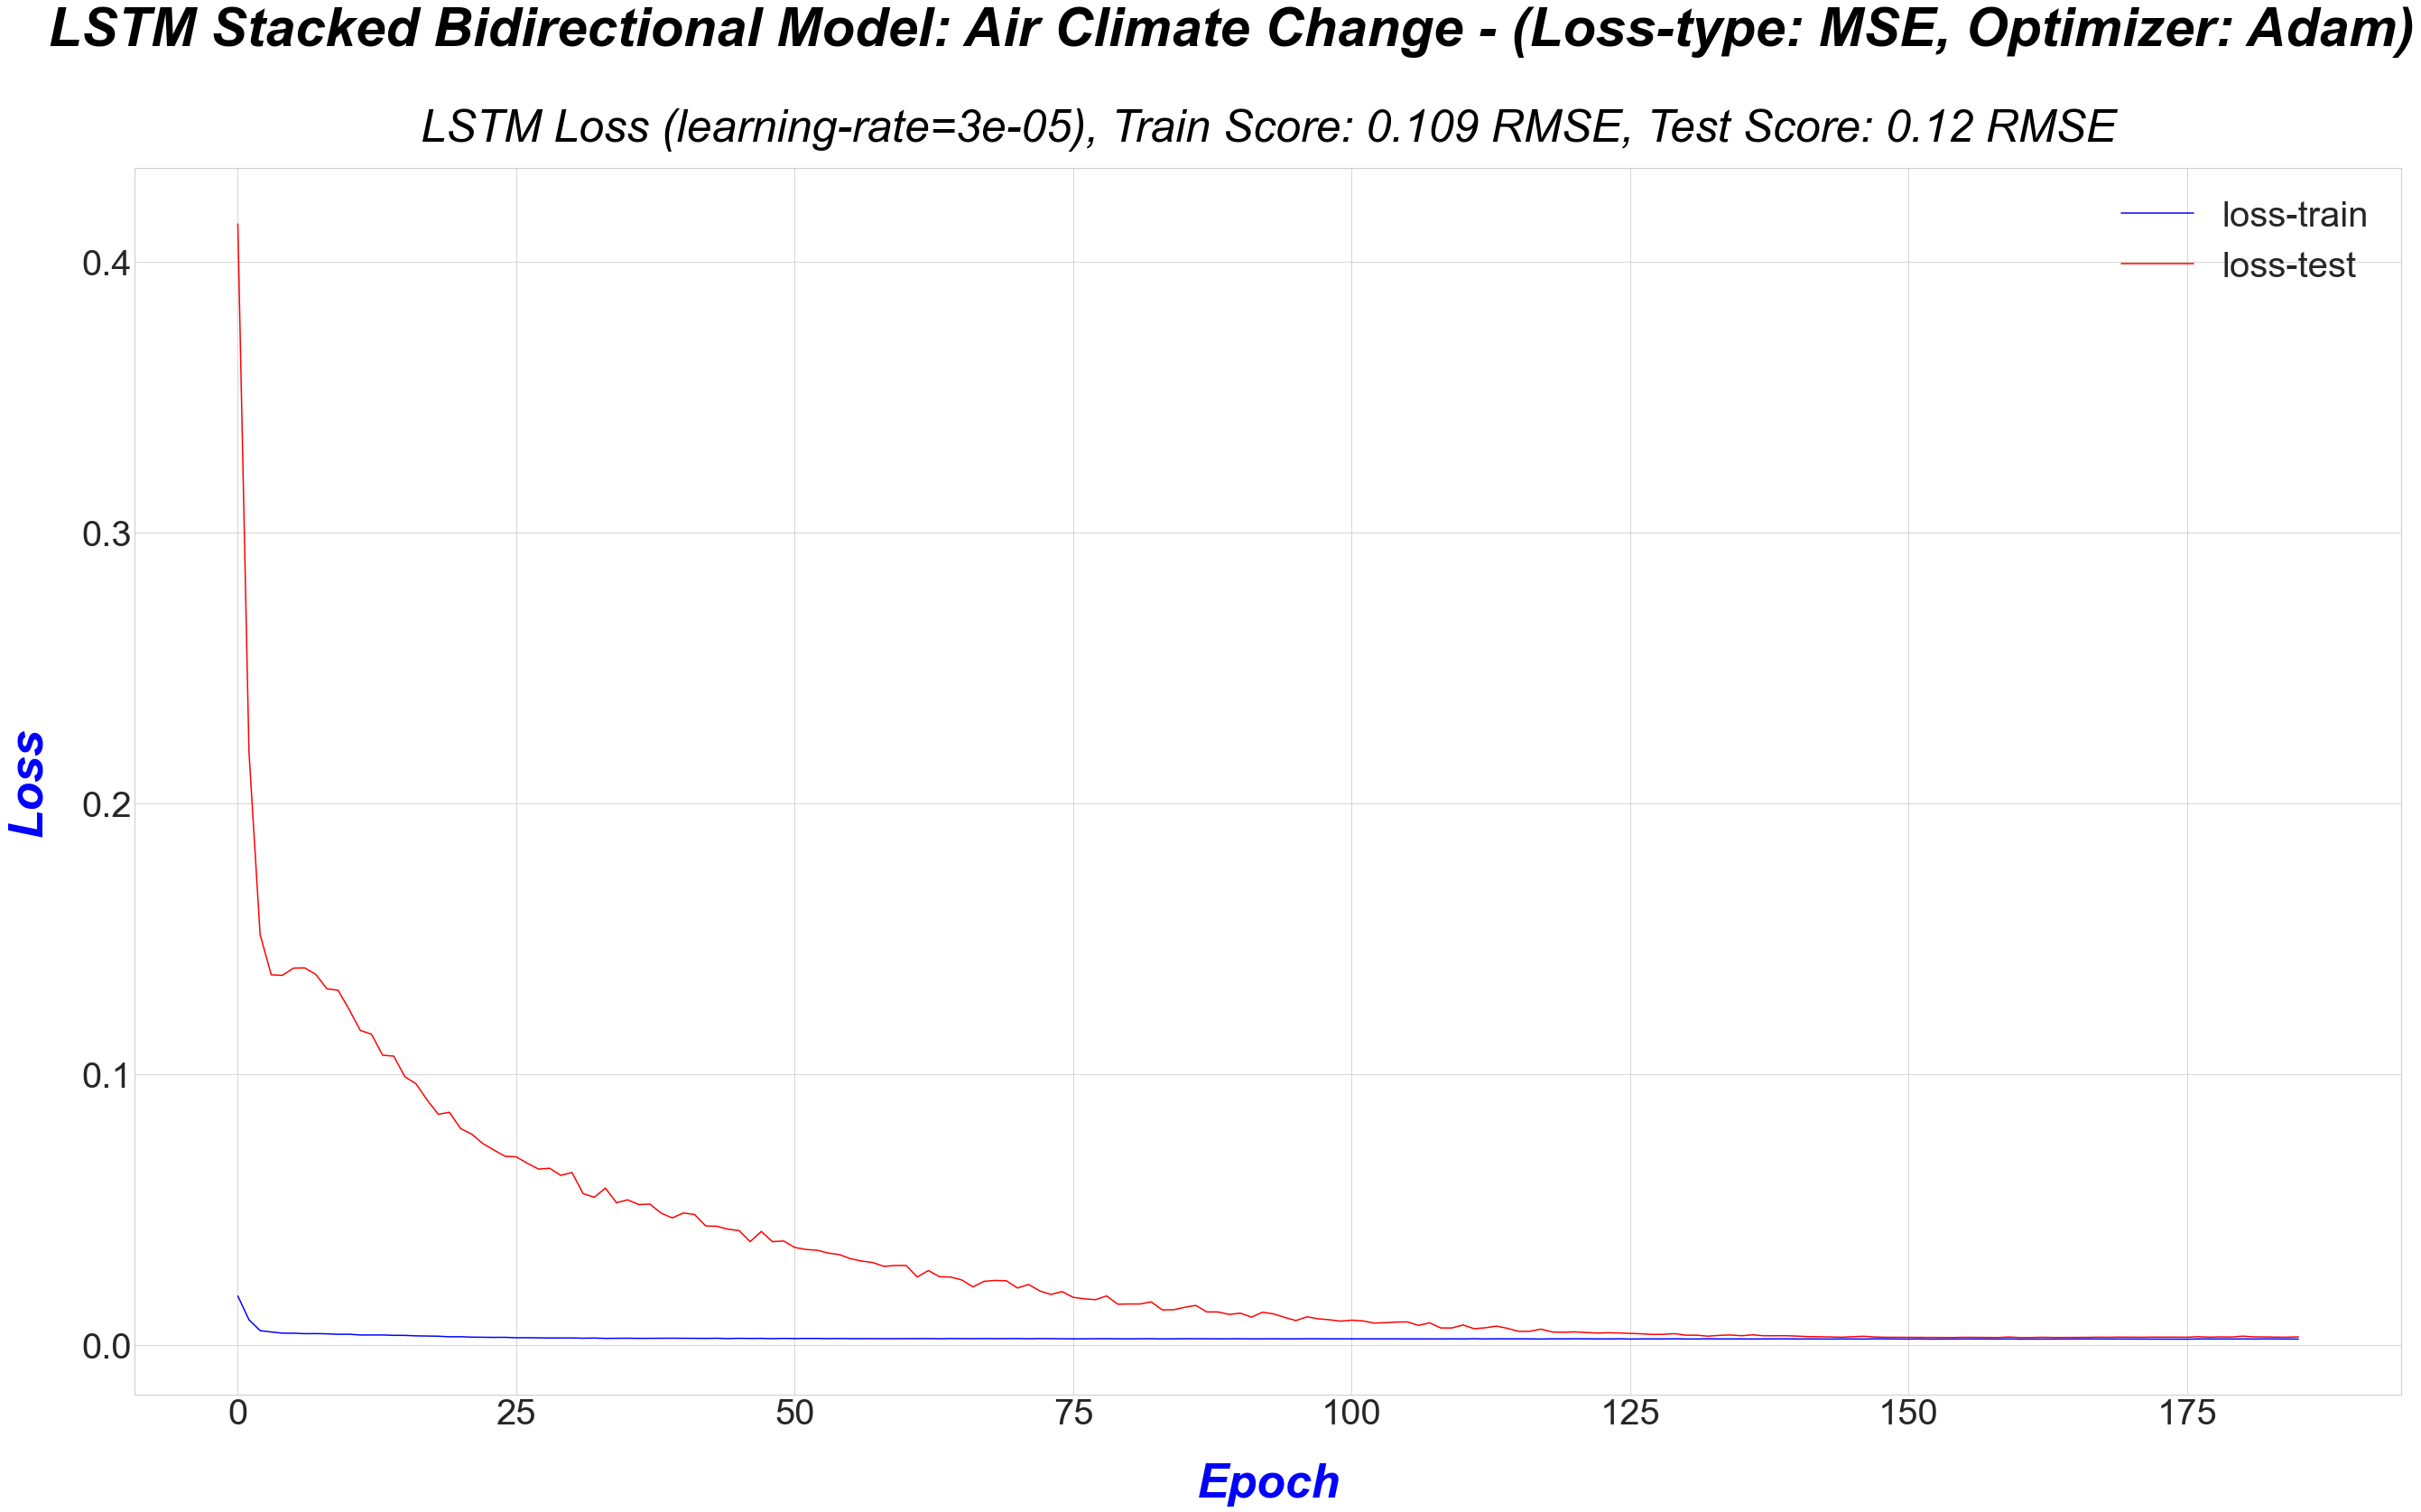

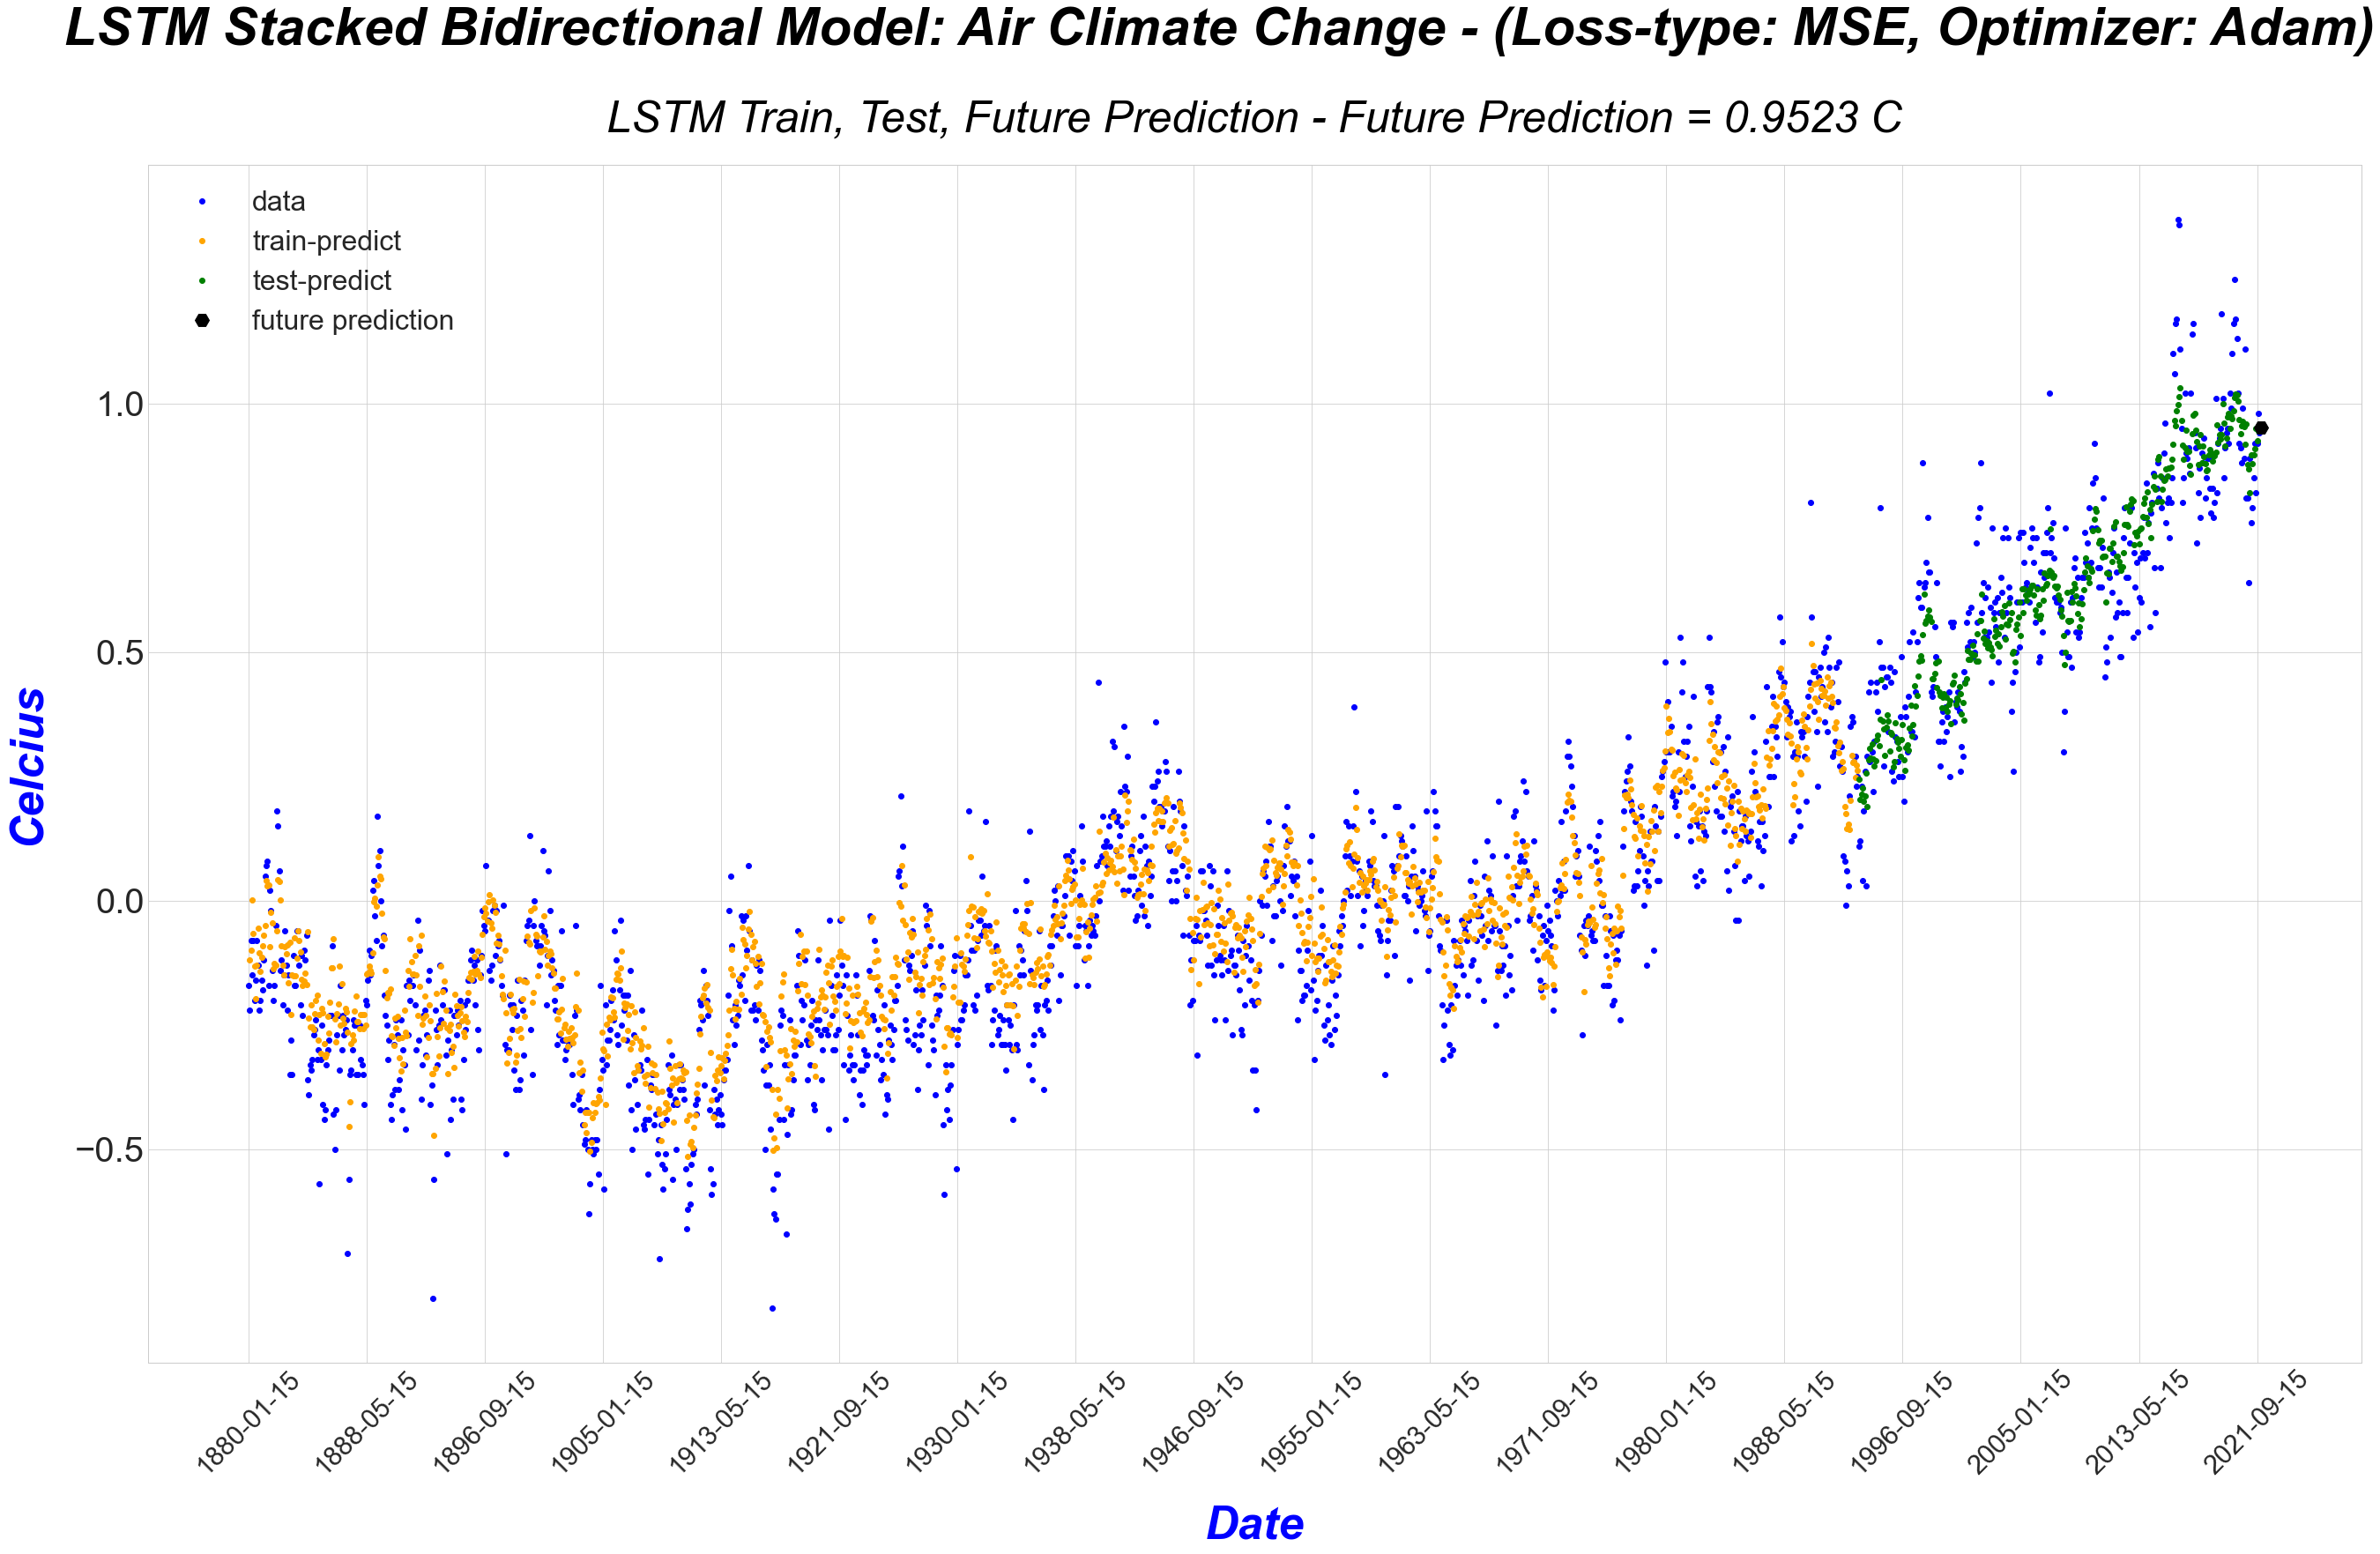

In [673]:
#
# Plot main dataset bidirectional LSTM model
#

plt.style.use('seaborn-whitegrid')

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(out_col)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(out_col)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(look_back*2)+1:len(ds)-1, :] = testPredict
testPredictPlot[len(trainPredict)+(look_back):len(ds), :] = testPredict   

futurePredictPlot = np.empty_like(out_col)
futurePredictPlot[:, :] = np.nan
futurePredictPlot = np.append(futurePredictPlot, future_prediction)
#print(futurePredictPlot)

epochs = range(len(history.history['loss']))

#
# Plot Loss graph
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")

plt.plot(epochs, history.history['loss'], "b", label='loss-train')
plt.plot(epochs, history.history['val_loss'], "r", label='loss-test')

plt.suptitle('LSTM Stacked Bidirectional Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam)', fontsize=60, weight='bold', style='italic', color='black')
plt.title('LSTM Loss (learning-rate=' + str(lrate) + ')' + ', Train Score: %.3f RMSE' % (trainScore) + ', Test Score: %.2f RMSE' % (testScore), fontsize=50, weight='normal', style='italic', color='black', pad=30)

ax.legend(fontsize=40)
ax.tick_params(axis='both', labelsize=32)
ax.set_xlabel('Epoch', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.set_ylabel('Loss', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(True)
plt.savefig("./images/main-lstm-bidirectional-loss.png")
plt.show();


#
# Time prediction plot
#
fig, ax = plt.subplots(1, 1, figsize=(45, 25))
ax.set_facecolor("white")
plt.plot(orig_x_axis, orig_plot_data, 'bo', markersize=6, label="data")  # Blue
plt.plot(orig_x_axis, trainPredictPlot, 'o', color='orange', markersize=6, label='train-predict')  # Orange
plt.plot(orig_x_axis, testPredictPlot, 'go', markersize=6, label='test-predict')   # Green
plt.plot(future_x_axis, futurePredictPlot, 'kH', markersize=16, label='future prediction')

plt.suptitle('LSTM Stacked Bidirectional Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam)', fontsize=60, weight='bold', style='italic', color='black')
plt.title('LSTM Train, Test, Future Prediction - Future Prediction = %.4f C' % future_prediction[0][0], fontsize=50, weight='normal', style='italic', color='black', pad=38)

ax.legend(fontsize=32)
ax.tick_params(labelsize=20, width=20) #ax.tick_params(labelcolor='r', labelsize='medium', width=3)
ax.set_xlabel('Date', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.set_ylabel('Celcius', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.xaxis.set_major_locator(ticker.MaxNLocator(20))
ax.xaxis.set_minor_locator(ticker.MaxNLocator(40))
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=30)
plt.yticks(fontsize=40)
plt.grid(True)
plt.savefig("./images/main-lstm-bidirectional-plot.png")
plt.show();

In [666]:
# Make sure original plot data never changed throughout all of the processing and copying of dataframes
# If it did then something was copied by reference instead of copied by value - and overwritten later

orig_plot_data

array([-0.17, -0.22, -0.08, ...,  0.92,  0.98,  0.94])